In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder ,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.express as px
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.utils.class_weight import compute_sample_weight

#WITH SMOTE

# import xgb.XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
# from imblearn.pipeline import Pipeline
# smotenc = SMOTENC(categorical_features= , random_state=42)

# Compute class weights
# class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTENC

# Example dataset
data = {
    'Age': [25, 30, 35, 40, 45, 22, 38, 40],  # continuous
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],  # categorical
    'Income': [50000, 60000, 55000, 65000, 70000, 48000, 62000, 58000],  # continuous
    'Purchased': [0, 1, 0, 0, 1, 0, 0, 1]  # target variable
}

df = pd.DataFrame(data)

# Encode the categorical 'Gender' column
df['Gender'] = df['Gender'].astype('category').cat.codes

# Features and target variable
X = df.drop('Purchased', axis=1)
y = df['Purchased']

# Identify the index of the categorical column
categorical_features = [1]  # 'Gender' is the categorical column

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_features, k_neighbors= 2, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# Convert resampled data back to a DataFrame for inspection
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Purchased'] = y_resampled

# Check the resampled target distribution
print(df_resampled['Purchased'].value_counts())

Purchased
0    5
1    5
Name: count, dtype: int64


In [ ]:
df.head()

,Age,Gender,Income,Purchased
0,25,1,50000,0
1,30,0,60000,1
2,35,1,55000,0
3,40,0,65000,0
4,45,1,70000,1


In [ ]:
print(df_resampled['Purchased'].value_counts())

Purchased
0    5
1    5
Name: count, dtype: int64


In [ ]:
df_resampled

,Age,Gender,Income,Purchased
0,25,1,50000,0
1,30,0,60000,1
2,35,1,55000,0
3,40,0,65000,0
4,45,1,70000,1
5,22,0,48000,0
6,38,1,62000,0
7,40,0,58000,1
8,44,0,67798,1
9,32,0,59559,1


In [ ]:
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}() Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [ ]:
# #Testing with a dry run
# rf_params = {
#     'rf__max_depth': [1,3,5,None],
#     'rf__random_state' : [42]
# }


# lr_params = {
#     'lr__max_iter': [100, 200, 500],  # Maximum iterations for solvers
#     'lr__random_state': [42]  # Random state for reproducibility
# }

# svc_params = {
#     'svc__C': [0.01, 100],  # Regularization parameter
#     'svc__random_state': [42]  # Random state for reproducibility
# }

# knn_params = {
#     'knn__n_neighbors': [3, 7, 11],          # Different values for number of neighbors
#     'knn__n_jobs': [-1]                            # Utilize all CPU cores
# }

# xgb_params = {
#     'xgb__n_estimators': [100, 200, 300],
#     'xgb__eval_metric' : ['logloss'],
#     'xgb__random_state' : [42],
#     'xgb__use_label_encoder' : [False]

# }

# cb_params = {
#     'cb__iterations': [200, 500, 1000],
#     'cb__random_state' : [42],
#     'cb__verbose' : [0]
# }

In [ ]:
# dummy for testing
rf_params = {
    'rf__max_depth': [1,3,5,None],
    'rf__n_estimators': [50, 100, 150, 200, 250, 300],
    'rf__min_samples_split' : [2, 5, 7],
    'rf__max_features' : ['sqrt', 'log2', None],
    'rf__n_jobs': [-1],
    'rf__random_state' : [42]
}

# logistic_params = {
#     'lr__alpha': [1],    # Regularization strength
#     'lr__penalty': ['l2', 'l1'],     # Type of regularization
#     'lr__random_state' : [42],
#     'lr__loss' : ['log_loss'],
#     'lr__eta0': [0.1],
#     'lr__max_iter': [100],
#     'lr__class_weight' : ['balanced']
# }

# svc_params = {
#     'svc__alpha': [1],    # Regularization strength
#     'svc__penalty': ['l2', 'l1'],     # Type of regularization
#     'svc__random_state' : [42],
#     'svc__loss' : ['hinge'],
#     'svc__eta0': [0.1],
#     'svc__max_iter': [100],
#     'svc__class_weight' : ['balanced'],
#     'svc__random_state' : [42]
# }


lr_params = {
    'lr__C': [0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'lr__penalty': ['l1', 'l2', 'elasticnet'],  # Type of regularization
    'lr__solver': ['saga', 'lbfgs'],  # Different solvers for optimization
    'lr__class_weight': [None],  # Class weights for imbalanced data
    'lr__max_iter': [100, 200, 500],  # Maximum iterations for solvers
    'lr__multi_class': ['multinomial'],  # One-vs-rest vs multinomial for multiclass problems
    'lr__random_state': [42]  # Random state for reproducibility
}

svc_params = {
    'svc__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'svc__class_weight': [None],  # Class weight for handling class imbalance
    'svc__loss': ['hinge', 'squared_hinge'],  # Type of loss function
    'svc__max_iter': [1000],  # Maximum iterations for the solver
    'svc__multi_class': ['crammer_singer'],  # One-vs-rest or Crammer-Singer for multiclass
    'svc__penalty': ['l2'],  # L2 regularization
    'svc__random_state': [42]  # Random state for reproducibility
}

knn_params = {
    'knn__n_neighbors': [3, 5, 7, 11],          # Different values for number of neighbors
    'knn__weights': ['uniform', 'distance'],       # Use both uniform and distance weighting
    'knn__algorithm': ['ball_tree', 'kd_tree'],  # Try different search algorithms
    'knn__leaf_size': [10, 30, 50],                # Different leaf sizes for tree-based algorithms
    'knn__metric': ['minkowski', 'euclidean', 'manhattan'],  # Common distance metrics
    'knn__n_jobs': [-1]                            # Utilize all CPU cores
}

xgb_params = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__gamma': [0, 0.1, 0.3],
    # 'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__eval_metric' : ['logloss'],
    'xgb__random_state' : [42],
    'xgb__use_label_encoder' : [False]
}


cb_params = {
    'cb__iterations': [200, 500, 1000],
    'cb__depth': [4, 6, 8],
    'cb__learning_rate': [0.01, 0.1, 0.2],
    'cb__l2_leaf_reg': [1, 3, 5],
    'cb__bagging_temperature': [0, 0.5, 1],
    # 'cb__subsample': [0.8, 1],
    'cb__random_state' : [42],
    'cb__verbose' : [0]
}

model_config = {
    'rf' : {
        'model_name' : 'RandomForest',
        'model_obj' : RandomForestClassifier(),
        'model_params' : rf_params
    },
    'lr' : {
        'model_name' : 'LogisticRegression',
        'model_obj' : LogisticRegression(multi_class='auto'),
        # 'model_obj' :  SGDClassifier(loss='log_loss', random_state=42),
        'model_params' : lr_params
    },
    'svc' : {
        'model_name' : 'SupportVectorClassifier',
        'model_obj' : LinearSVC(),
        # 'model_obj' :  SGDClassifier(loss='hinge', random_state=42),
        'model_params' : svc_params
    },
    'knn' : {
        'model_name' : 'KNNClassifier',
#         'model_obj' : LogisticRegression(multi_class='auto'),
        'model_obj' :  SGDClassifier(loss='log_loss', random_state=42),
        'model_params' : knn_params
    },
    'xgb' : {
        'model_name' : 'XGBoostClassifier',
#         'model_obj' : LogisticRegression(multi_class='auto'),
        'model_obj' :  XGBClassifier(loss='log_loss', random_state=42),
        'model_params' : xgb_params
    },
    'cb' : {
        'model_name' : 'CatBoostClassifier',
#         'model_obj' : LogisticRegression(multi_class='auto'),
        'model_obj' :  CatBoostClassifier(random_state=42),
        'model_params' : cb_params
    }
}

"""
access model object --> model_config[model_name][model_obj]
access model parameters --> model_config[model_name][model_params]
"""

"""
Store best parameters of the model after CV.

Structure of the dict:
model_best_params = {
    "lr" : {
        'max_depth' : None,
        'max_features' : None,
        'min_samples_split' : 5,
        'n_estimators' : 250
    }
}

access model params as --> model_best_params["lr"]
"""
model_best_params = {}


"""
Store model results
"""

model_results = {}

In [ ]:
@timeit
def return_preprocess_TF(numerical_features, ohe_features):
    preprocess_transformer = ColumnTransformer(
    transformers=[
        ('STDScaling', StandardScaler(), numerical_features),
        ('OneHotEncoding', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist'), ohe_features)
    ],
        remainder='passthrough'
    )

    return preprocess_transformer

def perform_preprocess_X(preprocess_TF, X, only_transform=False):
    if only_transform:
        return preprocess_TF.transform(X)
    else:
        return preprocess_TF.fit_transform(X)

@timeit
def build_model_pipeline(model_name, model, train_best_model=False, preprocessTF=None):
    if train_best_model:
        best_model = model
        best_parameters = model_best_params[model_name]

#         print("Train the Best Model ..." + best_model)
        print("Train the Best Model with parameters ..." + str(best_parameters))


        model_pipeline = Pipeline(steps = [(model_name, best_model) \
                                      ]
                             )
        return model_pipeline
    else:
        model_pipeline = Pipeline(steps = [(model_name, model) \
                                          ]
                                 )
        return model_pipeline

@timeit
def train(X, y, model_name, model, scoring = 'accuracy', preprocessTF=None):
    print("model_name = ", model_name)
    model_pipeline = build_model_pipeline(model_name, model, preprocessTF=preprocessTF)
    print("Starting model training ................")
    print("Shape of X passed to train = " , str(X.shape))
    print("Shape of y passed to train = " , str(y.shape))
    print("Shape of y passed to train = " , str(np.unique(y)))


    # To suppress warning messages
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid = GridSearchCV(model_pipeline, model_config[model_name]['model_params'], \
                            cv = 5, scoring = scoring)
        grid.fit(X, y)

    return grid, grid.best_estimator_

@timeit
def set_model_params(grid):
    """
    get
    1) best parameters
    2) best scores
    3) cv results dict - use this for graphs x = run_number, y = accuracy score; label = hyperparameters label
    """

    #1) Store the best parameters from pipeline obj in model_best_params and extract the model names after removing "__" in the key names
    model_name = list(pd.DataFrame(grid.cv_results_)['params'].loc[0].keys())[0].split("__")[0]
    print("**************")
    print("model_name = " + model_name)
    model_best_params[model_name] = {}
    model_results[model_name] = {}
    for i in list(pd.DataFrame(grid.cv_results_)['params'].loc[0].keys()):
        key_name = i.split("__")[1]
        model_best_params[model_name][key_name] = grid.best_params_[i]

    print("Best model parameters are : ")
    print(model_best_params[model_name])

    #2) Store model results in model_results dict
    model_results[model_name]["best_score"] = grid.best_score_
    model_results[model_name]["cv_mean_scores"] = grid.cv_results_['mean_test_score']
    model_results[model_name]["cv_hyperparameters"] = grid.cv_results_['params']

    print("Best CV score : " + str(grid.best_score_))
    print("mean CV test accuracy : " + str(np.mean(grid.cv_results_['mean_test_score'])))

    # plot model performance scores
    # fig = px.line(x=np.arange(len(model_results[model_name]["cv_mean_scores"])), y=model_results[model_name]["cv_mean_scores"], hover_name=[str(i) for i in model_results[model_name]["cv_hyperparameters"]])
    # fig.update_traces(mode="markers+lines")

    # fig.show()


@timeit
def train_best_model(X, y, model_name, model, preprocessTF=None):
    print("model_name = ", model_name)

    # Already transformed for SMOTE
    X_transformed = X
    # X_transformed = preprocessTF.transform(X)

    # To suppress warning messages
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_transformed, y)
#         model_pipeline = build_model_pipeline(model_name, model, train_best_model = True, preprocessTF=preprocessTF)
#         model_pipeline.fit(X, y)

    return model

@timeit
def predict(model_name, model, X, y):
    y_pred = model.predict(X)

    if model_name != "svc":
        y_pred_probs = model.predict_proba(X)
    else:
        y_pred_probs = None

    return y_pred, y_pred_probs

@timeit
def build_stacking_model():
    pass


@timeit
def performance_metrics(model_name, msg, model, X, y, target_mapping, preprocess_TF):
    """
    1) accuracy
    2) F1 for each class and weightage
    3) confusion matrix heatmap
    4) AUC-ROC score and curve
    5) PR score
    """
    print(f"Performance of {model_name} on {msg}")
    # y_pred, y_pred_probs = predict(model_name, model, preprocess_TF.transform(X), y)
    # Already transformed X
    y_pred, y_pred_probs = predict(model_name, model, X, y)
    print("Classification report")
    cnf_matrix = confusion_matrix(y, y_pred)
    sns.heatmap(cnf_matrix, cmap = 'Blues', cbar=False, annot=True, fmt='d', annot_kws={"size": 12})
    plt.xticks(np.arange(7) + 0.5, list(target_mapping), rotation=45, ha="right", fontsize=12)
    plt.yticks(np.arange(7) + 0.5, list(target_mapping), rotation=0, fontsize=12) ## get labels from le_target object

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.show()
    print("\n")
    print("************Classfication report*************")
    print("\n")

    print(classification_report(y, y_pred))

    d = pd.DataFrame(classification_report(y, y_pred, target_names=list(target_mapping), output_dict=True))
    d.pop('accuracy')
    d.pop('macro avg')
    d.pop('weighted avg')

    model_results[model_name]["clf_report"] = d.T

    print("**********************************")
    print("Accuracy")
    print(accuracy_score(y, y_pred))


@timeit
def visualize_model_predictions():
    """
    1) heatmap of confusion matrix
    2) AUC-ROC for each class
    3) Plot 2d PCAs/T-SNE/LDA
    """
    pass

@timeit
def save_model(model_name, model):
    model_name = f"{model_name}" + ".pkl"
    print("saving model = " + model_name)
    with open(model_name, "wb") as f:
        dump(model, f, protocol=5)

@timeit
def load_model(model_pkl_path):
    print("loading model pickle from the path = " + model_pkl_path)
    with open(model_pkl_path, "rb") as f:
        clf = load(f)

    return clf

@timeit
def tune_prob_threshold():
    """
    Adjust probabilities based on AUC-ROC
    """
    pass

In [ ]:
def main(train_df):
    # Encode Traget
    # Use this label encoder object to inverse transform label predictions
    le_target = LabelEncoder()
    train_df['NObeyesdad_label'] = le_target.fit_transform(train_df['NObeyesdad'])

    le_target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
#     print(le_target_mapping)

    le_target_inv_mapping = dict(zip(le_target.transform(le_target.classes_), le_target.classes_))
#     print(le_target_inv_mapping)

    """
    The experimentation for features is as follows:
    1) drop id + response + response_label
    2) Add BMI and scale it
    3) Add Age as categorical and remove from numericals
    """

    X = train_df.drop(labels=['id', 'NObeyesdad', 'NObeyesdad_label'], axis=1)
#     X = train_df.drop(labels=['id', 'NObeyesdad', 'NObeyesdad_label'], axis=1)
#     X = train_df.drop(labels=['id', 'NObeyesdad', 'NObeyesdad_label'], axis=1)

    y = train_df['NObeyesdad_label']

    # Split into train and Validation before any preprocessing on dependent variables
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    numerical_features = ['Age', 'Height', 'Weight']
    ohe_features = list(set(X.columns) - set(['Age', 'Height', 'Weight', 'NObeyesdad_label', 'NObeyesdad']))
    target = 'NObeyesdad_label'

    print("Numerical Features")
#     print(numerical_features)

    print("OHE Features")
#     print(ohe_features)


    # Preprocess X
    # Use this preprocess object to transform any dataframe
    """
    Operations that can be performed on the preprocess object:
    1) Std Scaler - what is the mean
    2) OHE - category mappings
    3) transform() on new X data
    """
    preprocess_transformer = return_preprocess_TF(numerical_features, ohe_features)
    preprocess_transformer.fit(X_train)

    print("Before SMOTE: ")
    print(X_train.shape)
    print(y_train.shape)

    features_out = list(preprocess_transformer.transformers_[0][1].get_feature_names_out()) + list(preprocess_transformer.transformers_[1][1].get_feature_names_out())
    # features_out
    # pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out).head()


    # Identify the index of the categorical column
    categorical_features = [1]  # 'Gender' is the categorical column

    # Apply SMOTE-NC
    smote_nc = SMOTENC(categorical_features=ohe_features, random_state=42)
    X_train, y_train = smote_nc.fit_resample(X_train, y_train)

    X_train = pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out)

    # X_train, y_train = smote.fit_resample(pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out), y_train)

    print("After SMOTE: ")
    print(X_train.shape)
    print(y_train.shape)

    unique, frequency = np.unique(y_train, return_counts = True)

    # convert both into one numpy array
    count = np.asarray((unique, frequency))

    print("The values and their frequency after are:\n",
          count)
    # Now build the model pipelines

    X_val = pd.DataFrame(preprocess_transformer.fit_transform(X_val), columns=features_out)

    """
    Diagnosis for model pipleine objects:
    1) RF
    i) Get the important features
    ii) Plot a bar graph
    iii) do feature selection

    2) Logistic
    i) Check independent vs logodds
    ii) interpret coefficients
    iii) get probabilities
    iv) wald's test

    """
    grid_rf, grid_rf_best = train(X_train, y_train, model_name = 'rf', model = RandomForestClassifier(), preprocessTF=preprocess_transformer)

    #update the model parameters dict
    set_model_params(grid_rf)

    """
    Assumptions of logistic model:
    1) Binary response
    2) linearity between x and log-odds (in case not linear, apply tansformation on that column)
    3) no multicollinarity
    4) large sample size
    5) independence of obeservations
    """
    grid_lr, grid_lr_best = train(X_train, y_train, model_name = 'lr', model = LogisticRegression(), preprocessTF=preprocess_transformer)

    #update the model parameters dict
    set_model_params(grid_lr)

    grid_svc, grid_svc_best = train(X_train, y_train, model_name = 'svc', model = LinearSVC(), preprocessTF=preprocess_transformer)

    #update the model parameters dict
    set_model_params(grid_svc)


    grid_xgb, grid_xgb_best = train(X_train, y_train, model_name = 'xgb', model = XGBClassifier(), preprocessTF=preprocess_transformer)

    #update the model parameters dict
    set_model_params(grid_xgb)


    grid_knn, grid_knn_best = train(X_train, y_train, model_name = 'knn', model = KNeighborsClassifier(), preprocessTF=preprocess_transformer)

    #update the model parameters dict
    set_model_params(grid_knn)


    grid_cb, grid_cb_best = train(X_train, y_train, model_name = 'cb', model = CatBoostClassifier(), preprocessTF=preprocess_transformer)

    #update the model parameters dict
    set_model_params(grid_cb)

    print("model training done......................")
    print("retraining the models with best parameters")
    #Training the model with best parameters
#     best_rf_pipeline = train_best_model(X_train, y_train, model_name = 'rf', model = RandomForestClassifier(**model_best_params['rf']), preprocessTF=preprocess_transformer)
#     best_lr_pipeline = train_best_model(X_train, y_train, model_name = 'lr', model = SGDClassifier(**model_best_params['lr']), preprocessTF=preprocess_transformer)

    best_rf = train_best_model(X_train, y_train, model_name = 'rf', model = RandomForestClassifier(**model_best_params['rf']), preprocessTF=preprocess_transformer)
    best_lr = train_best_model(X_train, y_train, model_name = 'lr', model = LogisticRegression(**model_best_params['lr']), preprocessTF=preprocess_transformer)
    best_svc = train_best_model(X_train, y_train, model_name = 'svc', model = LinearSVC(**model_best_params['svc']), preprocessTF=preprocess_transformer)
    best_xgb = train_best_model(X_train, y_train, model_name = 'xgb', model = XGBClassifier(**model_best_params['xgb']), preprocessTF=preprocess_transformer)
    best_cb = train_best_model(X_train, y_train, model_name = 'cb', model = CatBoostClassifier(**model_best_params['cb']), preprocessTF=preprocess_transformer)
    best_knn = train_best_model(X_train, y_train, model_name = 'knn', model = KNeighborsClassifier(**model_best_params['knn']), preprocessTF=preprocess_transformer)

    print("**********************************************")
    print("COMPUTING THE PERFORMANCE.....................")

    performance_metrics('rf', "train", best_rf, X_train, y_train, le_target_mapping, preprocess_transformer)
    performance_metrics('rf', "validation", best_rf, X_val, y_val, le_target_mapping, preprocess_transformer)

    performance_metrics('lr', "train", best_lr, X_train, y_train, le_target_mapping, preprocess_transformer)
    performance_metrics('lr', "validation", best_lr, X_val, y_val, le_target_mapping, preprocess_transformer)

    performance_metrics('svc', "train", best_svc, X_train, y_train, le_target_mapping, preprocess_transformer)
    performance_metrics('svc', "validation", best_svc, X_val, y_val, le_target_mapping, preprocess_transformer)

    performance_metrics('xgb', "train", best_xgb, X_train, y_train, le_target_mapping, preprocess_transformer)
    performance_metrics('xgb', "validation", best_xgb, X_val, y_val, le_target_mapping, preprocess_transformer)

    performance_metrics('knn', "train", best_knn, X_train, y_train, le_target_mapping, preprocess_transformer)
    performance_metrics('knn', "validation", best_knn, X_val, y_val, le_target_mapping, preprocess_transformer)

    performance_metrics('cb', "train", best_cb, X_train, y_train, le_target_mapping, preprocess_transformer)
    performance_metrics('cb', "validation", best_cb, X_val, y_val, le_target_mapping, preprocess_transformer)

    grid_models = [grid_rf, grid_lr, grid_svc, grid_xgb, grid_knn, grid_cb]
    best_models = [best_rf, best_lr, best_svc, best_xgb, best_knn, best_cb]

    return le_target, preprocess_transformer, grid_models, best_models

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/capstone/medical/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/capstone/medical/test.csv")

train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = np.round(train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])
test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = np.round(test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])


train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].astype('int32').astype('object')
test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].astype('int32').astype('object')

In [ ]:
# Encode Traget
# Use this label encoder object to inverse transform label predictions
le_target = LabelEncoder()
train_df['NObeyesdad_label'] = le_target.fit_transform(train_df['NObeyesdad'])

le_target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
#     print(le_target_mapping)

le_target_inv_mapping = dict(zip(le_target.transform(le_target.classes_), le_target.classes_))
#     print(le_target_inv_mapping)

"""
The experimentation for features is as follows:
1) drop id + response + response_label
2) Add BMI and scale it
3) Add Age as categorical and remove from numericals
"""
train_df['bmi'] = train_df['Weight'] / (train_df['Height'])**2
X = train_df.drop(labels=['id', 'Height', 'Weight', 'NObeyesdad', 'NObeyesdad_label'], axis=1)
#     X = train_df.drop(labels=['id', 'NObeyesdad', 'NObeyesdad_label'], axis=1)
#     X = train_df.drop(labels=['id', 'NObeyesdad', 'NObeyesdad_label'], axis=1)

y = train_df['NObeyesdad_label']

# Split into train and Validation before any preprocessing on dependent variables
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_features = ['Age', 'bmi']
ohe_features = list(set(X.columns) - set(['Age', 'Height', 'Weight', 'bmi', 'NObeyesdad_label', 'NObeyesdad']))
target = 'NObeyesdad_label'

print("Numerical Features")
#     print(numerical_features)

print("OHE Features")
#     print(ohe_features)


# Preprocess X
# Use this preprocess object to transform any dataframe
"""
Operations that can be performed on the preprocess object:
1) Std Scaler - what is the mean
2) OHE - category mappings
3) transform() on new X data
"""
# preprocess_transformer = return_preprocess_TF(numerical_features, ohe_features)
# preprocess_transformer.fit(X_train)

print("Before SMOTE: ")
print(X_train.shape)
print(y_train.shape)

# features_out = list(preprocess_transformer.transformers_[0][1].get_feature_names_out()) + list(preprocess_transformer.transformers_[1][1].get_feature_names_out())
# features_out
# pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out).head()


# Identify the index of the categorical column
# categorical_features = ohe_features  # 'Gender' is the categorical column

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=ohe_features, random_state=42)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)


print("After SMOTE: ")
print(X_train.shape)
print(y_train.shape)


Numerical Features
OHE Features
Before SMOTE: 
(16606, 15)
(16606,)
After SMOTE: 
(22659, 15)
(22659,)


In [ ]:
preprocess_transformer = return_preprocess_TF(numerical_features, ohe_features)
preprocess_transformer.fit(X_train)

features_out = list(preprocess_transformer.transformers_[0][1].get_feature_names_out()) + list(preprocess_transformer.transformers_[1][1].get_feature_names_out())

print(features_out)

Function return_preprocess_TF() Took 0.0000 seconds
['Age', 'bmi', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking', 'CH2O_2', 'CH2O_3', 'Gender_Male', 'TUE_1', 'TUE_2', 'FCVC_2', 'FCVC_3', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'FAVC_yes', 'FAF_1', 'FAF_2', 'FAF_3', 'CALC_Sometimes', 'CALC_no', 'SMOKE_yes', 'SCC_yes', 'NCP_2', 'NCP_3', 'NCP_4', 'family_history_with_overweight_yes']


In [ ]:
X_train = pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out)
X_train.head()

,Age,bmi,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,CH2O_2,CH2O_3,Gender_Male,TUE_1,...,FAF_2,FAF_3,CALC_Sometimes,CALC_no,SMOKE_yes,SCC_yes,NCP_2,NCP_3,NCP_4,family_history_with_overweight_yes
0,-0.298200,0.199578,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.975141,-0.069239,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.987324,-1.487760,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.987324,0.028661,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.171517,0.798495,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
X_val = pd.DataFrame(preprocess_transformer.fit_transform(X_val), columns=features_out)
X_val.head()

,Age,bmi,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,CH2O_2,CH2O_3,Gender_Male,TUE_1,...,FAF_2,FAF_3,CALC_Sometimes,CALC_no,SMOKE_yes,SCC_yes,NCP_2,NCP_3,NCP_4,family_history_with_overweight_yes
0,-0.320467,-0.980419,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.013450,-1.019076,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.491078,0.776575,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.372516,1.341173,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.147221,0.170193,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_df[ohe_features].head()

,MTRANS,CH2O,Gender,TUE,FCVC,CAEC,FAVC,FAF,CALC,SMOKE,SCC,NCP,family_history_with_overweight
0,Public_Transportation,3,Male,1,2,Sometimes,yes,0,Sometimes,no,no,3,yes
1,Automobile,2,Female,1,2,Frequently,yes,1,no,no,no,3,yes
2,Public_Transportation,2,Female,2,2,Sometimes,yes,1,no,no,no,1,yes
3,Public_Transportation,2,Female,1,3,Sometimes,yes,1,Sometimes,no,no,3,yes
4,Public_Transportation,2,Male,1,3,Sometimes,yes,2,Sometimes,no,no,2,yes


Applying 5 feature selection techniques

1) Chi-squared

2) RF-Imp

3) RFE

4) Logistic-L1

5) SVM-L1

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
for i in ohe_features:
    res = chi2_contingency(pd.crosstab(train_df[i], train_df['NObeyesdad']))
    if res.pvalue < 0.05:
        print(f"There is association between NObeyesdad and {i} with a p-value of {res.pvalue}")
    else:
        print(f"There is no association between NObeyesdad and {i} with a p-value of {res.pvalue}")

There is association between NObeyesdad and CALC with a p-value of 0.0
There is association between NObeyesdad and family_history_with_overweight with a p-value of 0.0
There is association between NObeyesdad and SCC with a p-value of 3.870102954479357e-218
There is association between NObeyesdad and SMOKE with a p-value of 6.396981747148517e-44
There is association between NObeyesdad and CH2O with a p-value of 0.0
There is association between NObeyesdad and FCVC with a p-value of 0.0
There is association between NObeyesdad and CAEC with a p-value of 0.0
There is association between NObeyesdad and FAF with a p-value of 0.0
There is association between NObeyesdad and NCP with a p-value of 0.0
There is association between NObeyesdad and TUE with a p-value of 0.0
There is association between NObeyesdad and MTRANS with a p-value of 0.0
There is association between NObeyesdad and FAVC with a p-value of 0.0
There is association between NObeyesdad and Gender with a p-value of 0.0


In [ ]:
rf_imp = RandomForestClassifier(**{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42})
rf_imp.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
rf_imp.feature_importances_

array([1.51446599e-01, 4.64451212e-01, 1.95453895e-02, 1.66408265e-02,
       3.18645450e-02, 5.33450312e-03, 1.32995676e-03, 1.50975283e-02,
       1.65966709e-02, 2.32504504e-02, 2.63772554e-02, 1.71868360e-02,
       1.53385530e-02, 3.76618514e-03, 1.82468052e-02, 1.22303180e-02,
       6.61657579e-03, 4.52127169e-03, 1.71556981e-02, 6.94745966e-03,
       1.66569536e-02, 1.03467796e-02, 2.62095623e-04, 3.14329126e-04,
       1.59225594e-02, 2.99277857e-03, 1.43668108e-02, 6.51930543e-02])

In [ ]:
df_rf_imp = pd.DataFrame()
indices = np.argsort(rf_imp.feature_importances_)[::-1]
df_rf_imp ['features'] = [list(X_train.columns)[i] for i in indices]
df_rf_imp ['importance'] = rf_imp.feature_importances_[indices]
df_rf_imp

,features,importance
0,bmi,0.464451
1,Age,0.151447
2,Gender_Male,0.065193
3,family_history_with_overweight_yes,0.031865
4,FCVC_3,0.026377
5,FCVC_2,0.023250
6,CALC_Sometimes,0.019545
7,FAF_1,0.018247
8,CAEC_Frequently,0.017187
9,NCP_3,0.017156


In [ ]:
df_rf_imp[['col_name', 'category_name']] = df_rf_imp['features'].apply(lambda x: pd.Series(x.rsplit('_', 1)))
df_rf_imp

,features,importance,col_name,category_name
0,bmi,0.464451,bmi,NaN
1,Age,0.151447,Age,NaN
2,Gender_Male,0.065193,Gender,Male
3,family_history_with_overweight_yes,0.031865,family_history_with_overweight,yes
4,FCVC_3,0.026377,FCVC,3
5,FCVC_2,0.023250,FCVC,2
6,CALC_Sometimes,0.019545,CALC,Sometimes
7,FAF_1,0.018247,FAF,1
8,CAEC_Frequently,0.017187,CAEC,Frequently
9,NCP_3,0.017156,NCP,3


In [ ]:
df_rf_imp_mean = df_rf_imp.groupby('col_name')['importance'].sum().sort_values(ascending=False)
df_rf_imp_mean

,importance
col_name,
bmi,0.464451
Age,0.151447
Gender,0.065193
FCVC,0.049628
FAF,0.037094
CAEC,0.036292
CALC,0.036186
family_history_with_overweight,0.031865
CH2O,0.031694


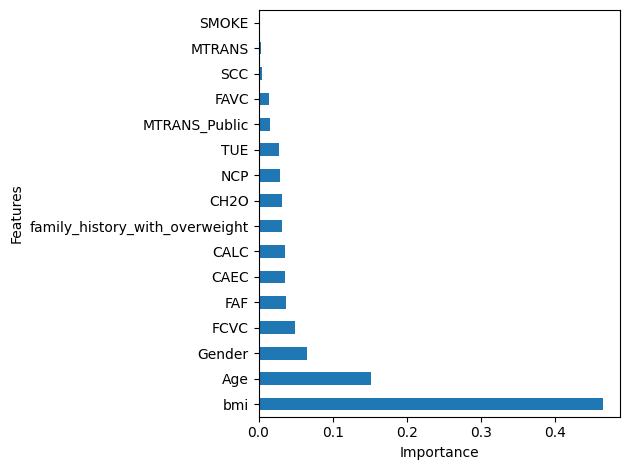

In [ ]:
df_rf_imp_mean.plot(kind='barh');
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
# features_out = list(preprocess_transformer.transformers_[0][1].get_feature_names_out()) + list(preprocess_transformer.transformers_[1][1].get_feature_names_out())
# # features_out
# pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out).head()

# X_resampled, y_resampled = smote.fit_resample(pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out), y_train)

In [ ]:
import time
start_time = time.time()
le_target, preprocess_transformer, grid_models, best_models = main(train_df)
print("--- %s seconds ---" % (time.time() - start_time))

Numerical Features
OHE Features
Function return_preprocess_TF() Took 0.0000 seconds
Before SMOTE: 
(16606, 16)
(16606,)
After SMOTE: 
(22659, 29)
(22659,)
The values and their frequency after are:
 [[   0    1    2    3    4    5    6]
 [3237 3237 3237 3237 3237 3237 3237]]
model_name =  rf
Function build_model_pipeline() Took 0.0000 seconds
Starting model training ................
Shape of X passed to train =  (22659, 29)
Shape of y passed to train =  (22659,)
Shape of y passed to train =  [0 1 2 3 4 5 6]
Function train() Took 3920.6223 seconds
**************
model_name = rf
Best model parameters are : 
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
Best CV score : 0.9190192189804355
mean CV test accuracy : 0.708857827546398
Function set_model_params() Took 0.0080 seconds
model_name =  lr
Function build_model_pipeline() Took 0.0000 seconds
Starting model training ................
Shape of X passed to train =  

In [ ]:
model_best_params

{'rf': {'max_depth': None, 'random_state': 42},
 'lr': {'max_iter': 200, 'random_state': 42},
 'svc': {'C': 100, 'random_state': 42},
 'xgb': {'eval_metric': 'logloss',
  'n_estimators': 300,
  'random_state': 42,
  'use_label_encoder': False},
 'knn': {'n_jobs': -1, 'n_neighbors': 3},
 'cb': {'iterations': 1000, 'random_state': 42, 'verbose': 0}}

In [ ]:
precision_results = pd.DataFrame(index=model_results['rf']['clf_report'].index)
recall_results = pd.DataFrame(index=model_results['rf']['clf_report'].index)
f1_results = pd.DataFrame(index=model_results['rf']['clf_report'].index)

for model in model_results.keys():
    # print(model_results[model]['clf_report']['precision'])
    precision_results[model] = model_results[model]['clf_report']['precision']
    recall_results[model] = model_results[model]['clf_report']['recall']
    f1_results[model] = model_results[model]['clf_report']['f1-score']

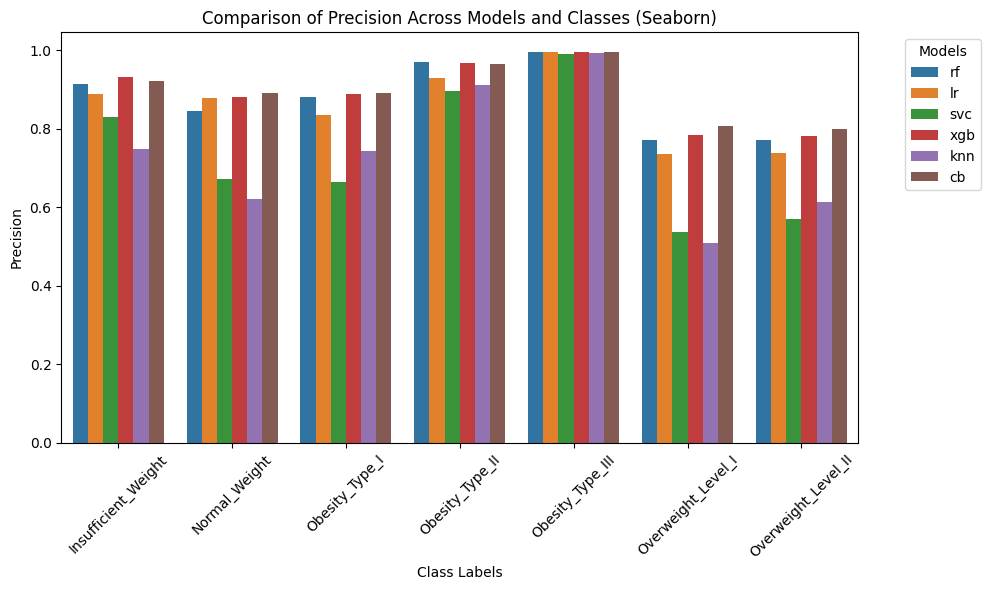

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=precision_results.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
plt.title('Comparison of Precision Across Models and Classes (Seaborn)')
plt.xlabel('Class Labels')
plt.ylabel('Precision')
plt.xticks(rotation=45)

# Move the legend outside the plot
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

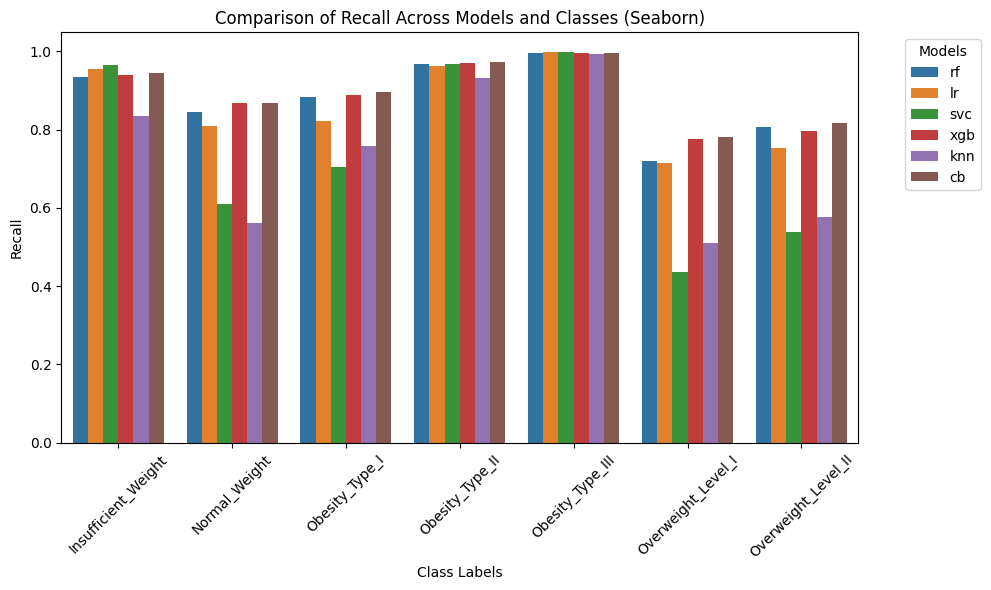

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=recall_results.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
plt.title('Comparison of Recall Across Models and Classes (Seaborn)')
plt.xlabel('Class Labels')
plt.ylabel('Recall')
plt.xticks(rotation=45)

# Move the legend outside the plot
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

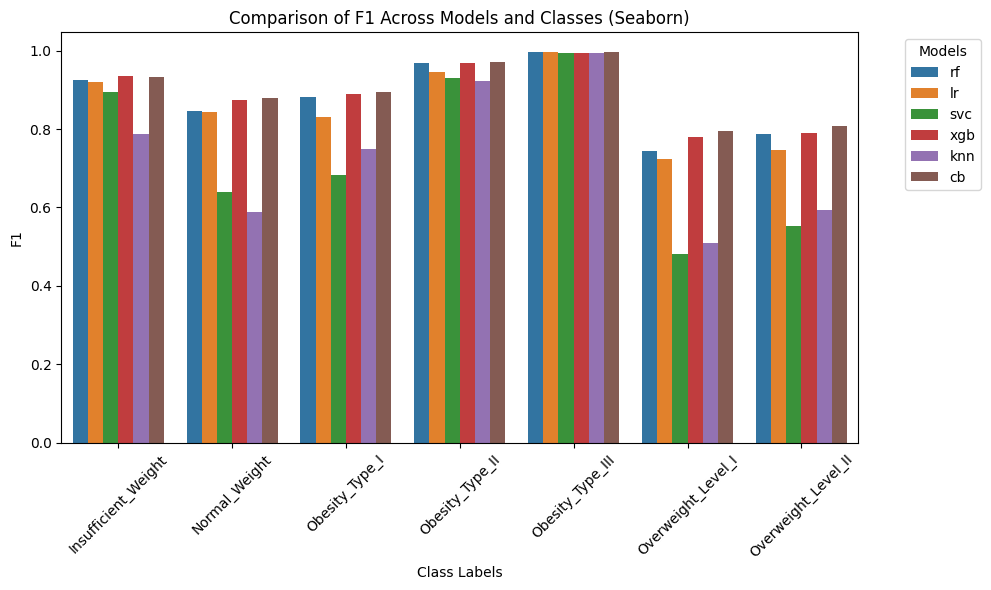

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=f1_results.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
plt.title('Comparison of F1 Across Models and Classes (Seaborn)')
plt.xlabel('Class Labels')
plt.ylabel('F1')
plt.xticks(rotation=45)

# Move the legend outside the plot
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# model_results[model_name]["cv_mean_scores"]

for model in model_results.keys():
    print(model_results[model]["cv_mean_scores"])

In [ ]:
# grid_models = [grid_rf, grid_lr, grid_svc, grid_xgb, grid_knn, grid_cb]
# best_models = [best_rf, best_lr, best_svc, best_xgb, best_knn, best_cb]
model_names = ['rf', 'lr', 'svc', 'xgb', 'knn', 'cb' ]

for model_name, grid_name in zip(model_names, grid_models):
    # save_model(model_name, grid_name)

    model_name = "/content/drive/MyDrive/capstone/medical/smote/grid_" + f"{model_name}" + ".pkl"
    print("saving model = " + model_name)
    with open(model_name, "wb") as f:
        dump(model, f, protocol=5)

    print(f"Model saved at: {model_name}")

In [ ]:
for model_name, best_name in zip(model_names, best_models):
    # save_model(model_name, best_name)

    model_name = "/content/drive/MyDrive/capstone/medical/smote/best_" + f"{model_name}" + ".pkl"
    print("saving model = " + model_name)
    with open(model_name, "wb") as f:
        dump(model, f, protocol=5)

    print(f"Model saved at: {model_name}")

In [ ]:
precision_results.to_csv('/content/drive/MyDrive/capstone/medical/smote/precision_results.csv')
recall_results.to_csv('/content/drive/MyDrive/capstone/medical/smote/recall_results.csv')
f1_results.to_csv('/content/drive/MyDrive/capstone/medical/smote/f1_results.csv')

In [ ]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.metrics import accuracy_score

# Load data (example using breast cancer dataset)
data = load_iris()
X = data.data
y = data.target


In [ ]:
import numpy
np.unique(y)

In [ ]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Load data (example using breast cancer dataset)
data = load_iris()
X = data.data
y = data.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function
# def objective(trial):
#     # Hyperparameters to tune
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1000),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         "random_strength": trial.suggest_float("random_strength", 1e-9, 10, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
#         "border_count": trial.suggest_int("border_count", 1, 255),
#         "verbose": 0,
#         "task_type": "CPU"  # 'GPU' if using GPU
#     }

#     # Create CatBoost model
#     model = CatBoostClassifier(**params)

#     # Train on the training set
#     model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

#     # Make predictions on the test set
#     y_pred = model.predict(X_test)

#     # Calculate accuracy
#     accuracy = accuracy_score(y_test, y_pred)

#     return accuracy

In [ ]:
## Optuna on Obesity dataset
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score


train_df = pd.read_csv("/content/drive/MyDrive/capstone/medical/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/capstone/medical/test.csv")

train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = np.round(train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])
test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = np.round(test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])


train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].astype('int32').astype('object')
test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].astype('int32').astype('object')


# Encode Traget
# Use this label encoder object to inverse transform label predictions
le_target = LabelEncoder()
train_df['NObeyesdad_label'] = le_target.fit_transform(train_df['NObeyesdad'])

le_target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
#     print(le_target_mapping)

le_target_inv_mapping = dict(zip(le_target.transform(le_target.classes_), le_target.classes_))
#     print(le_target_inv_mapping)

"""
The experimentation for features is as follows:
1) drop id + response + response_label
2) Add BMI and scale it
3) Add Age as categorical and remove from numericals
"""
train_df['bmi'] = train_df['Weight'] / (train_df['Height'])**2
X = train_df.drop(labels=['id', 'Height', 'Weight', 'NObeyesdad', 'NObeyesdad_label'], axis=1)
#     X = train_df.drop(labels=['id', 'NObeyesdad', 'NObeyesdad_label'], axis=1)
#     X = train_df.drop(labels=['id', 'NObeyesdad', 'NObeyesdad_label'], axis=1)

y = train_df['NObeyesdad_label']

# Split into train and Validation before any preprocessing on dependent variables
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_features = ['Age', 'bmi']
ohe_features = list(set(X.columns) - set(['Age', 'Height', 'Weight', 'bmi', 'NObeyesdad_label', 'NObeyesdad']))
target = 'NObeyesdad_label'

print("Numerical Features")
#     print(numerical_features)

print("OHE Features")
#     print(ohe_features)


# Preprocess X
# Use this preprocess object to transform any dataframe
"""
Operations that can be performed on the preprocess object:
1) Std Scaler - what is the mean
2) OHE - category mappings
3) transform() on new X data
"""
# preprocess_transformer = return_preprocess_TF(numerical_features, ohe_features)
# preprocess_transformer.fit(X_train)

print("Before SMOTE: ")
print(X_train.shape)
print(y_train.shape)

# features_out = list(preprocess_transformer.transformers_[0][1].get_feature_names_out()) + list(preprocess_transformer.transformers_[1][1].get_feature_names_out())
# features_out
# pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out).head()


# Identify the index of the categorical column
# categorical_features = ohe_features  # 'Gender' is the categorical column

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=ohe_features, random_state=42)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)


print("After SMOTE: ")
print(X_train.shape)
print(y_train.shape)


preprocess_transformer = return_preprocess_TF(numerical_features, ohe_features)
preprocess_transformer.fit(X_train)

features_out = list(preprocess_transformer.transformers_[0][1].get_feature_names_out()) + list(preprocess_transformer.transformers_[1][1].get_feature_names_out())

print(features_out)


X_train = pd.DataFrame(preprocess_transformer.fit_transform(X_train), columns=features_out)
X_val = pd.DataFrame(preprocess_transformer.transform(X_val), columns=features_out)

Numerical Features
OHE Features
Before SMOTE: 
(16606, 15)
(16606,)
After SMOTE: 
(22659, 15)
(22659,)
Function return_preprocess_TF() Took 0.0000 seconds
['Age', 'bmi', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking', 'CH2O_2', 'CH2O_3', 'Gender_Male', 'TUE_1', 'TUE_2', 'FCVC_2', 'FCVC_3', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'FAVC_yes', 'FAF_1', 'FAF_2', 'FAF_3', 'CALC_Sometimes', 'CALC_no', 'SMOKE_yes', 'SCC_yes', 'NCP_2', 'NCP_3', 'NCP_4', 'family_history_with_overweight_yes']


In [ ]:
def objective_multiclass(trial):
    # Hyperparameters to tune
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "task_type": "CPU",
        "loss_function": "MultiClass"  # Specify for multiclass classification
    }

    # Create CatBoost model
    model = CatBoostClassifier(**params)

    # Fit on training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=0)


    # Predict and compute accuracy
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_multiclass, n_trials=100)
# print(study.best_params)


In [ ]:
# Create a study for maximizing accuracy
study = optuna.create_study(direction="maximize")

# Optimize the study with the objective function and number of trials
study.optimize(objective_multiclass, n_trials=10)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-10-20 02:45:21,484] A new study created in memory with name: no-name-2c82263e-8f42-4ae5-9bbb-c5693d14ee69
[I 2024-10-20 02:45:55,876] Trial 0 finished with value: 0.8420038535645472 and parameters: {'iterations': 464, 'depth': 8, 'learning_rate': 0.023974492522515475, 'random_strength': 6.317472282218983e-07, 'bagging_temperature': 0.7020170348205793, 'l2_leaf_reg': 0.07436479106572068, 'border_count': 209}. Best is trial 0 with value: 0.8420038535645472.
[I 2024-10-20 02:46:29,532] Trial 1 finished with value: 0.7813102119460501 and parameters: {'iterations': 706, 'depth': 7, 'learning_rate': 0.00204518004385995, 'random_strength': 0.02208107481323713, 'bagging_temperature': 0.45475516565520624, 'l2_leaf_reg': 0.0014005377865833096, 'border_count': 198}. Best is trial 0 with value: 0.8420038535645472.
[I 2024-10-20 02:47:04,638] Trial 2 finished with value: 0.7916666666666666 and parameters: {'iterations': 741, 'depth': 7, 'learning_rate': 0.0023387668571684395, 'random_streng

Best hyperparameters:  {'iterations': 464, 'depth': 8, 'learning_rate': 0.023974492522515475, 'random_strength': 6.317472282218983e-07, 'bagging_temperature': 0.7020170348205793, 'l2_leaf_reg': 0.07436479106572068, 'border_count': 209}


In [ ]:
# Best trial's parameters
best_params = study.best_params
print(f"Best params: {best_params}")

# Best trial's accuracy
print(f"Best accuracy: {study.best_value}")


Best params: {'iterations': 464, 'depth': 8, 'learning_rate': 0.023974492522515475, 'random_strength': 6.317472282218983e-07, 'bagging_temperature': 0.7020170348205793, 'l2_leaf_reg': 0.07436479106572068, 'border_count': 209}
Best accuracy: 0.8420038535645472


In [ ]:
import optuna.visualization as vis

# Visualize the optimization history
vis.plot_optimization_history(study).show()

In [ ]:
# Visualize the parameter importance
vis.plot_param_importances(study).show()

In [ ]:
# Visualize hyperparameter relationships
vis.plot_parallel_coordinate(study).show()

START HERE

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder ,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.express as px
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.utils.class_weight import compute_sample_weight

#WITH SMOTE

# import xgb.XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
# from imblearn.pipeline import Pipeline
# smotenc = SMOTENC(categorical_features= , random_state=42)

# Compute class weights
# class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [4]:
## Optuna on Obesity dataset
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, make_scorer

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [5]:
# study.study_name

In [6]:
model_study_objs = {

}

best_models = {

}

model_results = {

}

In [7]:
# model_study_objs[study.study_name] = study
# model_study_objs[study.study_name].best_params
# # model_study_objs['no-name-2c82263e-8f42-4ae5-9bbb-c5693d14ee69'].best_params

In [8]:
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}() Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [9]:
@timeit
def return_preprocess_TF(numerical_features, ohe_features):
    preprocess_transformer = ColumnTransformer(
    transformers=[
        ('STDScaling', StandardScaler(), numerical_features),
        ('OneHotEncoding', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist'), ohe_features)
    ],
        remainder='passthrough'
    )

    return preprocess_transformer


@timeit
def train_best_model(X, y, model_name, model, preprocessTF=None):
    print("model_name = ", model_name)

    # Already transformed for SMOTE
    X_transformed = X
    # X_transformed = preprocessTF.transform(X)

    # To suppress warning messages
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_transformed, y)
#         model_pipeline = build_model_pipeline(model_name, model, train_best_model = True, preprocessTF=preprocessTF)
#         model_pipeline.fit(X, y)

    return model

@timeit
def predict(model_name, model, X, y):
    y_pred = model.predict(X)

    if model_name != "svc":
        y_pred_probs = model.predict_proba(X)
    else:
        y_pred_probs = None

    return y_pred, y_pred_probs

@timeit
def build_stacking_model():
    pass


@timeit
def performance_metrics(model_name, msg, model, X, y, target_mapping, preprocess_TF):
    """
    Note: X should already be preprocessed before passing to this function

    1) accuracy
    2) F1 for each class and weightage
    3) confusion matrix heatmap
    4) AUC-ROC score and curve
    5) PR score
    """
    print(f"Performance of {model_name} on {msg}")
    # y_pred, y_pred_probs = predict(model_name, model, preprocess_TF.transform(X), y)
    # Already transformed X
    y_pred, y_pred_probs = predict(model_name, model, X, y)
    print("Classification report")
    cnf_matrix = confusion_matrix(y, y_pred)
    sns.heatmap(cnf_matrix, cmap = 'Blues', cbar=False, annot=True, fmt='d', annot_kws={"size": 12})
    plt.xticks(np.arange(7) + 0.5, list(target_mapping), rotation=45, ha="right", fontsize=12)
    plt.yticks(np.arange(7) + 0.5, list(target_mapping), rotation=0, fontsize=12) ## get labels from le_target object

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.show()
    print("\n")
    print("************Classfication report*************")
    print("\n")

    print(classification_report(y, y_pred))

    d = pd.DataFrame(classification_report(y, y_pred, target_names=list(target_mapping), output_dict=True))
    d.pop('accuracy')
    d.pop('macro avg')
    d.pop('weighted avg')

    model_results[model_name] = {"clf_report": {

    }}

    model_results[model_name]["clf_report"] = d.T

    print("**********************************")
    print("Accuracy")
    print(accuracy_score(y, y_pred))

@timeit
def save_model(model_name, model):
    model_name = f"{model_name}" + ".pkl"
    print("saving model = " + model_name)
    with open(model_name, "wb") as f:
        dump(model, f, protocol=5)

@timeit
def load_model(model_pkl_path):
    print("loading model pickle from the path = " + model_pkl_path)
    with open(model_pkl_path, "rb") as f:
        clf = load(f)

    return clf


In [ ]:
def objective_multiclass_cb_ohe(trial, X_train, y_train, ohe_features):
    # Hyperparameters to tune
    # params = {
    #     "iterations": trial.suggest_int("iterations", 100, 1000),
    #     "depth": trial.suggest_int("depth", 4, 10),
    #     "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
    #     "random_strength": trial.suggest_float("random_strength", 1e-9, 10, log=True),
    #     "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
    #     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
    #     "border_count": trial.suggest_int("border_count", 1, 255),
    #     "task_type": "CPU",
    #     "loss_function": "MultiClass"  # Specify for multiclass classification
    # }

    print(" Tuning CatBoost Model")

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 8, step=2),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_state': 42,
        'verbose': 0,  # Fixed value,
        'loss_function': 'MultiClass',  # Specify for multiclass classification
        'early_stopping_rounds' : 10
    }
    # Set up cross-validation: using StratifiedKFold for multi-class classification
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store accuracy for each fold
    fold_accuracies = []

    # Perform 5-fold Stratified Cross-Validation
    for train_index, valid_index in skf.split(X_train, y_train):
        # Create training and validation sets from X_train and y_train
        X_train_fold, X_valid_fold = X_train.iloc[train_index, :], X_train.iloc[valid_index, :]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Initialize the CatBoost model with the suggested parameters
        model = CatBoostClassifier(**params, cat_features=ohe_features , class_weights=class_weights_dict)

        # Train on the current fold and validate using predefined X_val and y_val
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_valid_fold, y_valid_fold),  # Use the predefined global validation set
            early_stopping_rounds=10,
            verbose=0
        )

        # Predict on the validation fold from the CV process (X_valid_fold)
        y_pred = model.predict(X_valid_fold)

        # Calculate accuracy on the validation fold and store it
        accuracy = accuracy_score(y_valid_fold, y_pred)
        fold_accuracies.append(accuracy)

    # Return the mean accuracy across the 5 folds
    return sum(fold_accuracies) / len(fold_accuracies)

    # # Create CatBoost model
    # model = CatBoostClassifier(**params)


    # # Perform cross-validation
    # cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # # Return the average accuracy across the CV folds
    # return cv_scores.mean()

    # Fit on training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

    # model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=0)


    # # Predict and compute accuracy
    # y_pred = model.predict(X_val)

    # accuracy = accuracy_score(y_val, y_pred)

    # return accuracy

In [31]:
def objective_multiclass_cb(trial, X_train, y_train):
    # Hyperparameters to tune
    # params = {
    #     "iterations": trial.suggest_int("iterations", 100, 1000),
    #     "depth": trial.suggest_int("depth", 4, 10),
    #     "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
    #     "random_strength": trial.suggest_float("random_strength", 1e-9, 10, log=True),
    #     "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
    #     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
    #     "border_count": trial.suggest_int("border_count", 1, 255),
    #     "task_type": "CPU",
    #     "loss_function": "MultiClass"  # Specify for multiclass classification
    # }

    print(" Tuning CatBoost Model")

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 8, step=2),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_state': 42,
        'verbose': 0,  # Fixed value,
        'loss_function': 'MultiClass',  # Specify for multiclass classification
        'early_stopping_rounds' : 10
    }
    # Set up cross-validation: using StratifiedKFold for multi-class classification
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store accuracy for each fold
    fold_accuracies = []

    # Perform 5-fold Stratified Cross-Validation
    for train_index, valid_index in skf.split(X_train, y_train):
        # Create training and validation sets from X_train and y_train
        X_train_fold, X_valid_fold = X_train.iloc[train_index, :], X_train.iloc[valid_index, :]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Initialize the CatBoost model with the suggested parameters
        model = CatBoostClassifier(**params, class_weights=class_weights_dict)

        # Train on the current fold and validate using predefined X_val and y_val
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_valid_fold, y_valid_fold),  # Use the predefined global validation set
            early_stopping_rounds=10,
            verbose=0
        )

        # Predict on the validation fold from the CV process (X_valid_fold)
        y_pred = model.predict(X_valid_fold)

        # Calculate accuracy on the validation fold and store it
        accuracy = accuracy_score(y_valid_fold, y_pred)
        fold_accuracies.append(accuracy)

    # Return the mean accuracy across the 5 folds
    return sum(fold_accuracies) / len(fold_accuracies)

    # # Create CatBoost model
    # model = CatBoostClassifier(**params)


    # # Perform cross-validation
    # cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # # Return the average accuracy across the CV folds
    # return cv_scores.mean()

    # Fit on training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

    # model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=0)


    # # Predict and compute accuracy
    # y_pred = model.predict(X_val)

    # accuracy = accuracy_score(y_val, y_pred)

    # return accuracy


def objective_multiclass_rf(trial, X_train, y_train):
    # Hyperparameters to tune
    print(" Tuning Random Forest Model")
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [1, 3, 5, 10]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700, step=100),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 7, 10, 15]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [2, 5, 7, 10, 15]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 42
    }

    # {'max_depth': None, 'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt'}

    # Create RF model
    model = RandomForestClassifier(**params, class_weight=class_weights_dict)


    # Set up cross-validation: using StratifiedKFold for multi-class classification
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # Return the average accuracy across the CV folds
    return cv_scores.mean()

    # Fit on training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

    # model.fit(X_train, y_train)


    # # Predict and compute accuracy
    # y_pred = model.predict(X_val)

    # accuracy = accuracy_score(y_val, y_pred)

    # return accuracy

def objective_multiclass_lr(trial, X_train, y_train):
    # Hyperparameters to tune
    print(" Tuning Logistic Regression Model")

    # Suggest solver first
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])

    # Conditional logic for the penalty based on the solver
    penalty = 'l2'
    l1_ratio = None

    if solver == 'saga':
        # 'saga' supports 'l1', 'l2', and 'elasticnet'
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
        if penalty == 'elasticnet':
            l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1.0, log=True)

    # if solver == 'lbfgs':
    #     # 'lbfgs' only supports 'l2' or no penalty
    #     penalty = trial.suggest_categorical('penalty', ['l2'])
    # elif solver == 'saga':
    #     # 'saga' supports 'l1', 'l2', and 'elasticnet'
    #     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    #     if penalty == 'elasticnet':
    #         l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1.0, log=True)

    # Other hyperparameters
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_categorical('max_iter', [100, 200, 500])

    # Create Logistic Regression model with the selected hyperparameters
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        l1_ratio=l1_ratio,  # l1_ratio is only used when penalty is elasticnet
        max_iter=max_iter,
        multi_class='multinomial',
        random_state=42,
        class_weight=class_weights_dict
    )

    # Set up cross-validation: using StratifiedKFold for multi-class classification
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # Return the average accuracy across the CV folds
    return cv_scores.mean()

    # Fit on training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

    # model.fit(X_train, y_train)


    # # Predict and compute accuracy
    # y_pred = model.predict(X_val)

    # accuracy = accuracy_score(y_val, y_pred)

    # return accuracy


def objective_multiclass_svc(trial):
    # Hyperparameters to tune
    print(" Tuning Linear SVM Model")
    params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        # 'class_weight': None,  # Keeping class_weight None as per your GridSearch params
        'loss': trial.suggest_categorical('loss', ['hinge', 'squared_hinge']),
        'max_iter': 1000,  # Fixed value
        'multi_class': 'crammer_singer',
        'penalty': 'l2',
        'random_state': 42
    }

    # Create Linear SVC model
    model = LinearSVC(**params, class_weight=class_weights_dict)


    # Set up cross-validation: using StratifiedKFold for multi-class classification
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # Return the average accuracy across the CV folds
    return cv_scores.mean()

    # Fit on training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

    # model.fit(X_train, y_train)


    # # Predict and compute accuracy
    # y_pred = model.predict(X_val)

    # accuracy = accuracy_score(y_val, y_pred)

    # return accuracy

def objective_multiclass_xgb(trial, X_train, y_train, X_val_transformed):
    # Hyperparameters to tune
    print(" Tuning XGBoost Model")

    # alpha = 1e-05 to 1e-08

    # colsample_bytree = 0.8 to 0.55

    # eta = 0.12 to 0.3

    # gamma = 1e-05 to 0.1

    # lambda = 1e-05 to 1.63-e08

    # learning rate = 0.1 to 0.2

    # max_depth = 9 to 12

    # min_child_weight = 1, 3, 10

    # n_estimators = 200 to 1000 step = 150

    # subsample = 0.7 to 0.9

    params = {
        'objective': 'multi:softprob',
        'num_class': 7,
        'eval_metric': 'mlogloss',  # Ensure that the eval_metric is specified here
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'lambda': trial.suggest_float('lambda', 1e-08, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-02, 5.0, log=True),
        'eta': trial.suggest_float('eta', 0.1, 0.3),
        'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 15, 21),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.55, 0.8),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000, step=50),
        # 'reg_lambda' : trial.suggest_float('reg_lambda', 100, 700, step=100),
        # 'reg_alpha' : trial.suggest_float('reg_alpha', 100, 700, step=100),
        # 'max_depth': trial.suggest_int('xgb__max_depth', 3, 7),
        # 'gamma': trial.suggest_categorical('xgb__gamma', [0, 0.1, 0.3]),
        # 'colsample_bytree': trial.suggest_categorical('xgb__colsample_bytree', [0.8, 1.0]),
        # 'eval_metric': 'logloss',  # Fixed value
        'random_state': 42,
        'use_label_encoder': False
    }

    fold_accuracies = []

   # Set up cross-validation: using StratifiedKFold for multi-class classification
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Perform 5-fold cross-validation on X_train
    for train_index, valid_index in skf.split(X_train, y_train):
        # Create training and validation sets from X_train and y_train
        X_train_fold, X_valid_fold = X_train.iloc[train_index, :], X_train.iloc[valid_index, :]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

        # Create DMatrix for XGBoost (this is XGBoost's internal data structure)
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dvalid = xgb.DMatrix(X_valid_fold, label=y_valid_fold)
        dval_eval = xgb.DMatrix(X_val_transformed, label=y_val)  # Predefined validation set

        # Train the XGBoost model using the training fold
        model = xgb.train(
            params, dtrain,
            evals=[(dval_eval, "validation")],  # Use predefined global validation set for monitoring
            early_stopping_rounds=10,
            verbose_eval=False
        )

        # Predict on the validation fold from the CV process (X_valid_fold)
        y_pred = model.predict(dvalid)
        y_pred_labels = y_pred.argmax(axis=1)  # Get the predicted class labels

        # Calculate accuracy on the validation fold and store it
        accuracy = accuracy_score(y_valid_fold, y_pred_labels)
        fold_accuracies.append(accuracy)


    # Return the mean accuracy across the 5 folds
    return sum(fold_accuracies) / len(fold_accuracies)

    # # Create XGBoost model
    # model = XGBClassifier(**params)


    # # Perform cross-validation
    # cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # # Return the average accuracy across the CV folds
    # return cv_scores.mean()

    # # Fit on training data
    # model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # # model.fit(X_train, y_train)


    # # Predict and compute accuracy
    # y_pred = model.predict(X_val)

    # accuracy = accuracy_score(y_val, y_pred)

    # return accuracy

def objective_multiclass_knn(trial):
    # Hyperparameters to tune
    print(" Tuning KNN Model")
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 2001, 2501, step=70),
        # 'p': trial.suggest_int('p', 3, 9, step=2),
        'weights': trial.suggest_categorical('weights', ['distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree']),
        'leaf_size': trial.suggest_int('leaf_size', 3001, 3005, step=90),
        # 'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean']),
        'metric': trial.suggest_categorical('metric', ['euclidean']),
        'n_jobs': -1
    }

    # Create CatBoost model
    model = KNeighborsClassifier(**params)

    # Set up cross-validation: using StratifiedKFold for multi-class classification
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(accuracy_score))

    # Return the average accuracy across the CV folds
    return cv_scores.mean()

    # Fit on training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)


    # model.fit(X_train, y_train)


    # Predict and compute accuracy
    # y_pred = model.predict(X_val)

    # accuracy = accuracy_score(y_val, y_pred)

    # return accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_multiclass, n_trials=100)
# print(study.best_params)


In [11]:
def main(train_df):
  # Encode Traget
  # Use this label encoder object to inverse transform label predictions
  le_target = LabelEncoder()
  train_df['NObeyesdad_label'] = le_target.fit_transform(train_df['NObeyesdad'])

  le_target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
  #     print(le_target_mapping)

  le_target_inv_mapping = dict(zip(le_target.transform(le_target.classes_), le_target.classes_))
  #     print(le_target_inv_mapping)

  """
  The experimentation for features is as follows:
  1) drop id + response + response_label
  2) Add BMI and scale it
  3) Add Age as categorical and remove from numericals
  """
  train_df['bmi'] = train_df['Weight'] / (train_df['Height'])**2
  X = train_df.drop(labels=['id', 'Height', 'Weight', 'NObeyesdad', 'NObeyesdad_label'], axis=1)
  y = train_df['NObeyesdad_label']

  # Split into train and Validation before any preprocessing on dependent variables
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  numerical_features = ['Age', 'bmi']
  ohe_features = list(set(X.columns) - set(['Age', 'Height', 'Weight', 'bmi', 'NObeyesdad_label', 'NObeyesdad']))
  target = 'NObeyesdad_label'

  print("Numerical Features")
  #     print(numerical_features)

  print("OHE Features")
  #     print(ohe_features)

  """
  Use the below code only if you want to use the class weights, else comment it
  """
  # Define your classes
  classes = np.unique(y_train)

  # Compute class weights
  class_weights = compute_class_weight('balanced', classes=classes, y=y_train)

  # Convert to a dictionary if needed for model use
  class_weights_dict = dict(zip(classes, class_weights))

  print("Class Weights: ", class_weights_dict)


  # Preprocess X
  # Use this preprocess object to transform any dataframe
  """
  Operations that can be performed on the preprocess object:
  1) Std Scaler - what is the mean
  2) OHE - category mappings
  3) transform() on new X data
  """

  print("Before SMOTE: ")
  print("Shape of X Train = " + str(X_train.shape))
  print("Shape of y Train = " + str(y_train.shape))
  unique, frequency = np.unique(y_train, return_counts = True)

  # convert both into one numpy array
  count = np.asarray((unique, frequency))

  print("The values and their frequency BEFORE are:\n",
        count)

  # Apply SMOTE-NC and pass the CATEGORICAL FEATURES argument
  smote_nc = SMOTENC(categorical_features=ohe_features, random_state=42)
  X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

  print("**********************************************")

  print("After SMOTE: ")
  print("Shape of X Train = " + str(X_train_smote.shape))
  print("Shape of y Train = " + str(y_train_smote.shape))
  unique, frequency = np.unique(y_train, return_counts = True)

  # convert both into one numpy array
  count = np.asarray((unique, frequency))

  print("The values and their frequency AFTER are:\n",
        count)


  # Now convert X_train and X_val to DataFrames after preprocessing
  # Before that, get column names to create the above DataFrame for X_train and X_val

  preprocess_transformer = return_preprocess_TF(numerical_features, ohe_features)
  preprocess_transformer.fit(X_train_smote)

  # Get the feature names after preprocessing
  features_out = list(preprocess_transformer.transformers_[0][1].get_feature_names_out()) + list(preprocess_transformer.transformers_[1][1].get_feature_names_out())
  # print(features_out)


  X_train_smote = pd.DataFrame(preprocess_transformer.transform(X_train_smote), columns=features_out)
  X_val_transformed = pd.DataFrame(preprocess_transformer.transform(X_val), columns=features_out)

  return le_target, class_weights_dict, preprocess_transformer, X_train, y_train, X_val, y_val, X_train_smote, y_train_smote, X_val_transformed, numerical_features, ohe_features


In [12]:
train_df = pd.read_csv("/content/drive/MyDrive/capstone/medical/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/capstone/medical/test.csv")

train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = np.round(train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])
test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = np.round(test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])


train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = train_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].astype('int32').astype('object')
test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']] = test_df[['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].astype('int32').astype('object')

In [13]:
n_trials = 25
n_splits = 5
le_target, class_weights_dict, preprocess_transformer, X_train, y_train, X_val, y_val, X_train_smote, y_train_smote, X_val_transformed, numerical_features, ohe_features = main(train_df)
le_target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))

Numerical Features
OHE Features
Class Weights:  {0: 1.1755627920147247, 1: 0.9623877137061722, 2: 1.0190230731467844, 3: 0.913119982404047, 4: 0.7328655280462509, 5: 1.2215683389730763, 6: 1.1755627920147247}
Before SMOTE: 
Shape of X Train = (16606, 15)
Shape of y Train = (16606,)
The values and their frequency BEFORE are:
 [[   0    1    2    3    4    5    6]
 [2018 2465 2328 2598 3237 1942 2018]]
**********************************************
After SMOTE: 
Shape of X Train = (22659, 15)
Shape of y Train = (22659,)
The values and their frequency AFTER are:
 [[   0    1    2    3    4    5    6]
 [2018 2465 2328 2598 3237 1942 2018]]
Function return_preprocess_TF() Took 0.0000 seconds


In [14]:
X_train_smote.shape, y_train_smote.shape #with OHE

((22659, 28), (22659,))

In [15]:
X_train.shape, y_train.shape #no OHE

((16606, 15), (16606,))

In [16]:
X_val.shape, y_val.shape #no OHE

((4152, 15), (4152,))

In [17]:
X_val_transformed.shape #with OHE

(4152, 28)

In [ ]:
# list(class_weights_dict)

In [ ]:
# !rm -rf /content/catboost_info

In [15]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16606 entries, 4515 to 7417
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          16606 non-null  object 
 1   Age                             16606 non-null  float64
 2   family_history_with_overweight  16606 non-null  object 
 3   FAVC                            16606 non-null  object 
 4   FCVC                            16606 non-null  object 
 5   NCP                             16606 non-null  object 
 6   CAEC                            16606 non-null  object 
 7   SMOKE                           16606 non-null  object 
 8   CH2O                            16606 non-null  object 
 9   SCC                             16606 non-null  object 
 10  FAF                             16606 non-null  object 
 11  TUE                             16606 non-null  object 
 12  CALC                            166

In [27]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, valid_index in skf.split(X_train, y_train):
      # Create training and validation sets from X_train and y_train
      X_train_fold, X_valid_fold = X_train.iloc[train_index, :], X_train.iloc[valid_index, :]
      y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]


[I 2024-10-22 01:47:08,202] A new study created in memory with name: cb_no_ohe


 Tuning CatBoost Model


[I 2024-10-22 01:56:34,804] Trial 0 finished with value: 0.8574010352452177 and parameters: {'iterations': 200, 'depth': 6, 'learning_rate': 0.01333924639018438, 'l2_leaf_reg': 5, 'bagging_temperature': 0.9184983270693128}. Best is trial 0 with value: 0.8574010352452177.


 Tuning CatBoost Model


[I 2024-10-22 02:04:57,589] Trial 1 finished with value: 0.8760087459059085 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.11709964918604304, 'l2_leaf_reg': 1, 'bagging_temperature': 0.09918018083043345}. Best is trial 1 with value: 0.8760087459059085.


{'iterations': 500, 'depth': 4, 'learning_rate': 0.11709964918604304, 'l2_leaf_reg': 1, 'bagging_temperature': 0.09918018083043345}
model training done......................
retraining the models with best parameters
model_name =  cb_no_ohe
Function train_best_model() Took 149.1792 seconds
**********************************************
COMPUTING THE PERFORMANCE.....................
Performance of cb_no_ohe on train
Function predict() Took 0.3039 seconds
Classification report


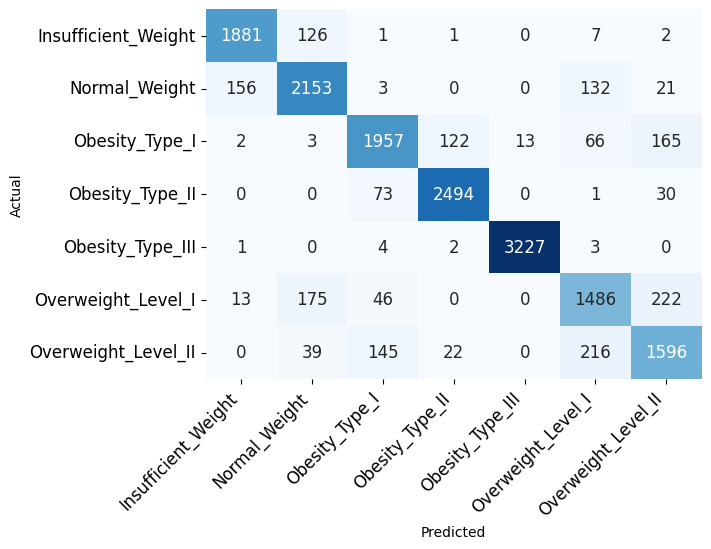



************Classfication report*************


              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2018
           1       0.86      0.87      0.87      2465
           2       0.88      0.84      0.86      2328
           3       0.94      0.96      0.95      2598
           4       1.00      1.00      1.00      3237
           5       0.78      0.77      0.77      1942
           6       0.78      0.79      0.79      2018

    accuracy                           0.89     16606
   macro avg       0.88      0.88      0.88     16606
weighted avg       0.89      0.89      0.89     16606

**********************************
Accuracy
0.890882813440925
Function performance_metrics() Took 0.7237 seconds
Performance of cb_no_ohe on validation
Function predict() Took 0.0826 seconds
Classification report


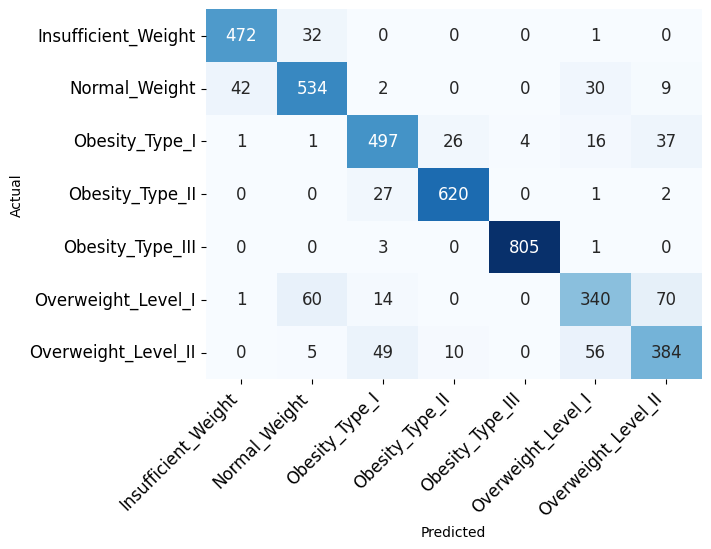



************Classfication report*************


              precision    recall  f1-score   support

           0       0.91      0.93      0.92       505
           1       0.84      0.87      0.86       617
           2       0.84      0.85      0.85       582
           3       0.95      0.95      0.95       650
           4       1.00      1.00      1.00       809
           5       0.76      0.70      0.73       485
           6       0.76      0.76      0.76       504

    accuracy                           0.88      4152
   macro avg       0.87      0.87      0.87      4152
weighted avg       0.88      0.88      0.88      4152

**********************************
Accuracy
0.8795761078998073
Function performance_metrics() Took 0.4319 seconds


In [29]:
n_trials = 2
n_splits = 5

# CATBOOST
study_cb = optuna.create_study(study_name = "cb_no_ohe", direction="maximize")
study_cb.optimize(lambda trial: objective_multiclass_cb_ohe(trial, X_train, y_train, ohe_features), n_trials=n_trials)
print(study_cb.best_params)

model_study_objs[study_cb.study_name] = study_cb

print("model training done......................")
print("retraining the models with best parameters")

best_models[study_cb.study_name] = train_best_model(X_train, y_train, model_name = study_cb.study_name, model = CatBoostClassifier(**model_study_objs[study_cb.study_name].best_params, cat_features=ohe_features, verbose=0), preprocessTF=preprocess_transformer)

print("**********************************************")
print("COMPUTING THE PERFORMANCE.....................")

performance_metrics(study_cb.study_name, "train", best_models[study_cb.study_name], X_train, y_train, le_target_mapping, preprocess_transformer)
performance_metrics(study_cb.study_name, "validation", best_models[study_cb.study_name], X_val, y_val, le_target_mapping, preprocess_transformer)

In [30]:
# Get feature importance
feature_importances = best_models[study_cb.study_name].get_feature_importance(Pool(X_train, y_train, cat_features=ohe_features))
for feature_name, importance in zip(X_train.columns, feature_importances):
    print(f'Feature: {feature_name}, Importance: {importance}')

Feature: Gender, Importance: 10.048978032716184
Feature: Age, Importance: 9.409823123281033
Feature: family_history_with_overweight, Importance: 2.1221542835667493
Feature: FAVC, Importance: 1.2034154251370848
Feature: FCVC, Importance: 5.156643666523451
Feature: NCP, Importance: 3.5296679007952623
Feature: CAEC, Importance: 2.5613198230854373
Feature: SMOKE, Importance: 0.027405610447355636
Feature: CH2O, Importance: 2.0835474592955263
Feature: SCC, Importance: 0.3698330990150782
Feature: FAF, Importance: 3.1026699173812315
Feature: TUE, Importance: 2.4287050429117074
Feature: CALC, Importance: 3.747033754363538
Feature: MTRANS, Importance: 2.4043389316492325
Feature: bmi, Importance: 51.80446392983106


[I 2024-10-22 02:16:38,761] A new study created in memory with name: cb


 Tuning CatBoost Model


[I 2024-10-22 02:19:58,612] Trial 0 finished with value: 0.8807540113483207 and parameters: {'iterations': 800, 'depth': 6, 'learning_rate': 0.020074376601741443, 'l2_leaf_reg': 1, 'bagging_temperature': 0.07595069148577704}. Best is trial 0 with value: 0.8807540113483207.


 Tuning CatBoost Model


[I 2024-10-22 02:20:15,967] Trial 1 finished with value: 0.8377688427841312 and parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.013661181562751763, 'l2_leaf_reg': 5, 'bagging_temperature': 0.8545154482705685}. Best is trial 0 with value: 0.8807540113483207.


{'iterations': 800, 'depth': 6, 'learning_rate': 0.020074376601741443, 'l2_leaf_reg': 1, 'bagging_temperature': 0.07595069148577704}
model training done......................
retraining the models with best parameters
model_name =  cb
Function train_best_model() Took 27.6321 seconds
**********************************************
COMPUTING THE PERFORMANCE.....................
Performance of cb on train
Function predict() Took 0.2177 seconds
Classification report


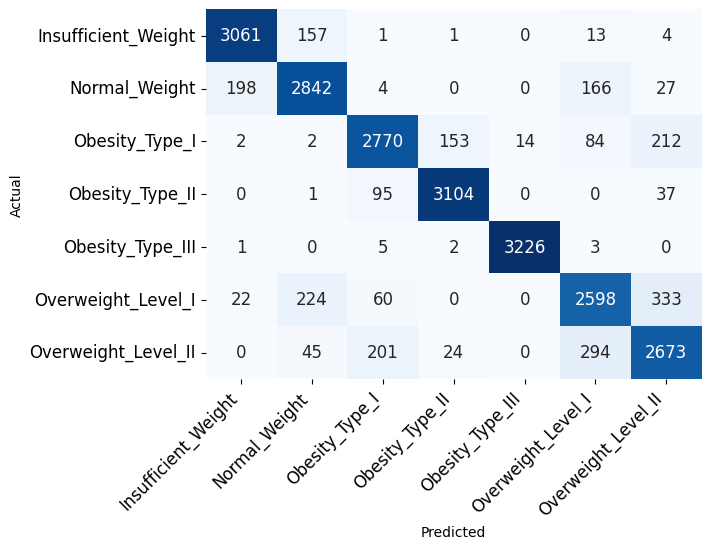



************Classfication report*************


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3237
           1       0.87      0.88      0.87      3237
           2       0.88      0.86      0.87      3237
           3       0.95      0.96      0.95      3237
           4       1.00      1.00      1.00      3237
           5       0.82      0.80      0.81      3237
           6       0.81      0.83      0.82      3237

    accuracy                           0.89     22659
   macro avg       0.89      0.89      0.89     22659
weighted avg       0.89      0.89      0.89     22659

**********************************
Accuracy
0.894743810406461
Function performance_metrics() Took 0.6650 seconds
Performance of cb on validation
Function predict() Took 0.0432 seconds
Classification report


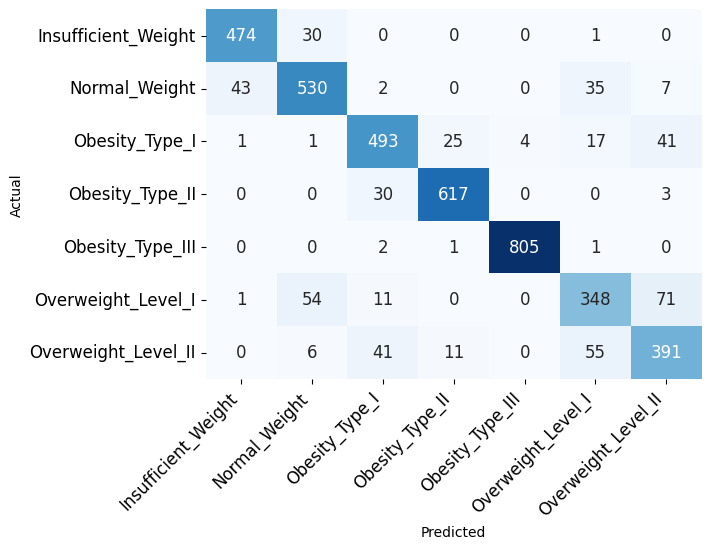



************Classfication report*************


              precision    recall  f1-score   support

           0       0.91      0.94      0.93       505
           1       0.85      0.86      0.86       617
           2       0.85      0.85      0.85       582
           3       0.94      0.95      0.95       650
           4       1.00      1.00      1.00       809
           5       0.76      0.72      0.74       485
           6       0.76      0.78      0.77       504

    accuracy                           0.88      4152
   macro avg       0.87      0.87      0.87      4152
weighted avg       0.88      0.88      0.88      4152

**********************************
Accuracy
0.8810211946050096
Function performance_metrics() Took 0.5391 seconds


In [32]:
# using weights
n_trials = 2
n_splits = 5

# CATBOOST
study_cb = optuna.create_study(study_name = "cb", direction="maximize")
study_cb.optimize(lambda trial: objective_multiclass_cb(trial, X_train_smote, y_train_smote), n_trials=n_trials)
print(study_cb.best_params)

model_study_objs[study_cb.study_name] = study_cb

print("model training done......................")
print("retraining the models with best parameters")

best_models[study_cb.study_name] = train_best_model(X_train_smote, y_train_smote, model_name = study_cb.study_name, model = CatBoostClassifier(**model_study_objs[study_cb.study_name].best_params, verbose=0), preprocessTF=preprocess_transformer)

print("**********************************************")
print("COMPUTING THE PERFORMANCE.....................")

performance_metrics(study_cb.study_name, "train", best_models[study_cb.study_name], X_train_smote, y_train_smote, le_target_mapping, preprocess_transformer)
performance_metrics(study_cb.study_name, "validation", best_models[study_cb.study_name], X_val_transformed, y_val, le_target_mapping, preprocess_transformer)


In [18]:
plot_optimization_history(study_cb).show()

In [19]:
plot_slice(study_cb).show()

In [20]:
plot_param_importances(study_cb).show()

[I 2024-10-22 02:24:54,118] A new study created in memory with name: rf


 Tuning Random Forest Model


[I 2024-10-22 02:26:12,936] Trial 0 finished with value: 0.8574078774386044 and parameters: {'max_depth': 10, 'n_estimators': 700, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.8574078774386044.


 Tuning Random Forest Model


[I 2024-10-22 02:26:18,576] Trial 1 finished with value: 0.721302849858667 and parameters: {'max_depth': 3, 'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 0 with value: 0.8574078774386044.


{'max_depth': 10, 'n_estimators': 700, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2'}
model training done......................
retraining the models with best parameters
model_name =  rf
Function train_best_model() Took 10.3577 seconds
**********************************************
COMPUTING THE PERFORMANCE.....................
Performance of rf on train
Function predict() Took 3.7648 seconds
Classification report


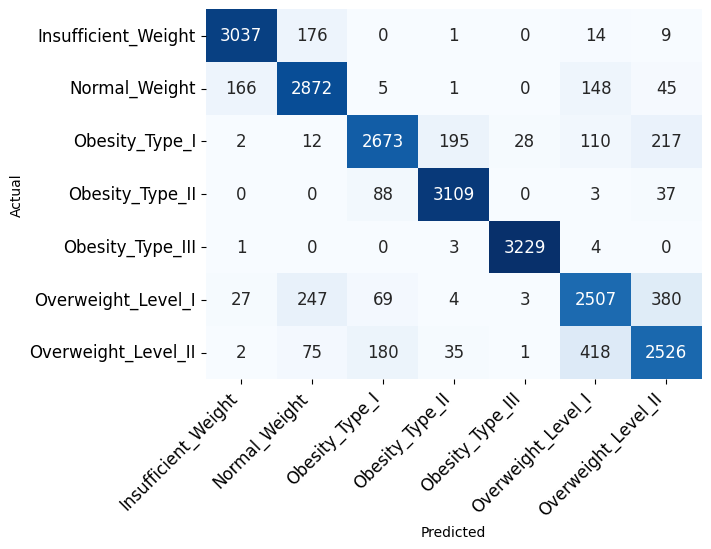



************Classfication report*************


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3237
           1       0.85      0.89      0.87      3237
           2       0.89      0.83      0.86      3237
           3       0.93      0.96      0.94      3237
           4       0.99      1.00      0.99      3237
           5       0.78      0.77      0.78      3237
           6       0.79      0.78      0.78      3237

    accuracy                           0.88     22659
   macro avg       0.88      0.88      0.88     22659
weighted avg       0.88      0.88      0.88     22659

**********************************
Accuracy
0.88057725407123
Function performance_metrics() Took 4.2014 seconds
Performance of rf on validation
Function predict() Took 0.6311 seconds
Classification report


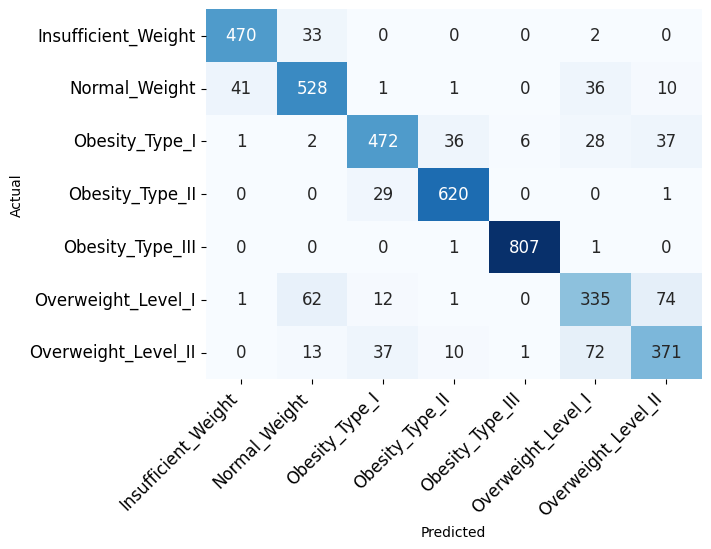



************Classfication report*************


              precision    recall  f1-score   support

           0       0.92      0.93      0.92       505
           1       0.83      0.86      0.84       617
           2       0.86      0.81      0.83       582
           3       0.93      0.95      0.94       650
           4       0.99      1.00      0.99       809
           5       0.71      0.69      0.70       485
           6       0.75      0.74      0.74       504

    accuracy                           0.87      4152
   macro avg       0.85      0.85      0.85      4152
weighted avg       0.87      0.87      0.87      4152

**********************************
Accuracy
0.8677745664739884
Function performance_metrics() Took 1.1481 seconds


In [34]:
# using weights
n_trials = 2
n_splits = 5

# RANDOM FOREST
study_rf = optuna.create_study(study_name = "rf", direction="maximize")
study_rf.optimize(lambda trial: objective_multiclass_rf(trial, X_train_smote, y_train_smote), n_trials=n_trials)
print(study_rf.best_params)

model_study_objs[study_rf.study_name] = study_rf

print("model training done......................")
print("retraining the models with best parameters")

best_models[study_rf.study_name] = train_best_model(X_train_smote, y_train_smote, model_name = study_rf.study_name, model = RandomForestClassifier(**model_study_objs[study_rf.study_name].best_params), preprocessTF=preprocess_transformer)

print("**********************************************")
print("COMPUTING THE PERFORMANCE.....................")

performance_metrics(study_rf.study_name, "train", best_models[study_rf.study_name], X_train_smote, y_train_smote, le_target_mapping, preprocess_transformer)
performance_metrics(study_rf.study_name, "validation", best_models[study_rf.study_name], X_val_transformed, y_val, le_target_mapping, preprocess_transformer)


RF Overfitting was reduced after removing max_depth = None and increasing min_samples_split and min_samples_leaf

In [22]:
plot_optimization_history(study_rf).show()

In [23]:
plot_slice(study_rf).show()

In [24]:
plot_param_importances(study_rf).show()

[I 2024-10-22 02:26:59,230] A new study created in memory with name: xgb
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:26:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Tuning XGBoost Model


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:26:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:26:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:27:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:27:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-10-22 02:27:00,475] Trial 0 finished with value: 0.8511410167828842 and paramete

 Tuning XGBoost Model


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:27:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:27:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:27:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:27:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:27:01] WAR

{'booster': 'gbtree', 'lambda': 0.0008383745552739807, 'alpha': 0.0118572812970662, 'eta': 0.18674084154823745, 'gamma': 8.626798593349581e-05, 'max_depth': 3, 'min_child_weight': 19, 'subsample': 0.8274108815451561, 'colsample_bytree': 0.677184819117386, 'learning_rate': 0.18271540779894244, 'n_estimators': 700}
model training done......................
retraining the models with best parameters
model_name =  xgb
Function train_best_model() Took 14.3035 seconds
**********************************************
COMPUTING THE PERFORMANCE.....................
Performance of xgb on train
Function predict() Took 1.9841 seconds
Classification report


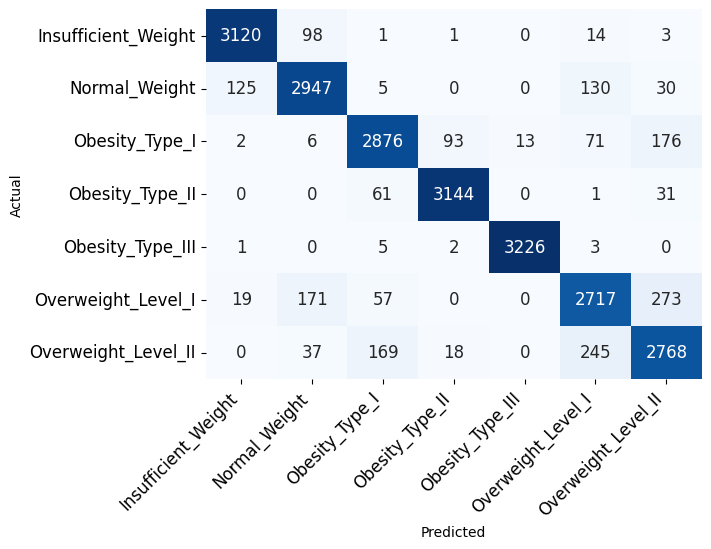



************Classfication report*************


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3237
           1       0.90      0.91      0.91      3237
           2       0.91      0.89      0.90      3237
           3       0.97      0.97      0.97      3237
           4       1.00      1.00      1.00      3237
           5       0.85      0.84      0.85      3237
           6       0.84      0.86      0.85      3237

    accuracy                           0.92     22659
   macro avg       0.92      0.92      0.92     22659
weighted avg       0.92      0.92      0.92     22659

**********************************
Accuracy
0.9178692793150625
Function performance_metrics() Took 2.4033 seconds
Performance of xgb on validation
Function predict() Took 0.3727 seconds
Classification report


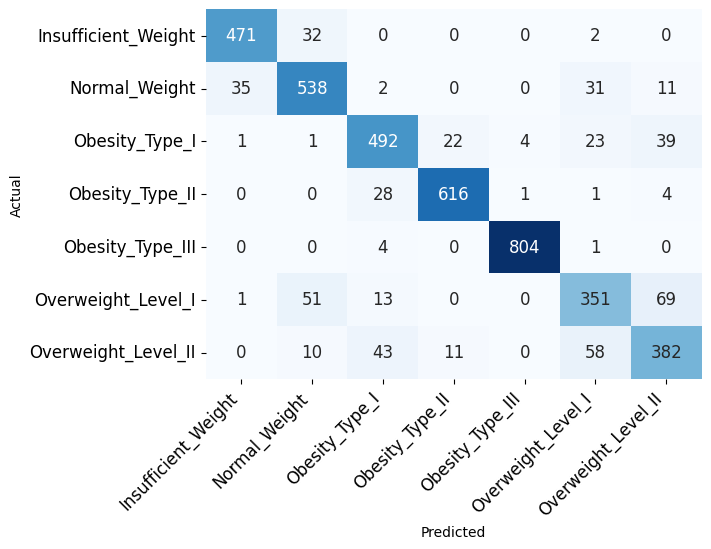



************Classfication report*************


              precision    recall  f1-score   support

           0       0.93      0.93      0.93       505
           1       0.85      0.87      0.86       617
           2       0.85      0.85      0.85       582
           3       0.95      0.95      0.95       650
           4       0.99      0.99      0.99       809
           5       0.75      0.72      0.74       485
           6       0.76      0.76      0.76       504

    accuracy                           0.88      4152
   macro avg       0.87      0.87      0.87      4152
weighted avg       0.88      0.88      0.88      4152

**********************************
Accuracy
0.880057803468208
Function performance_metrics() Took 0.7104 seconds


In [35]:
n_trials = 2
n_splits = 5

# XGB
study_xgb = optuna.create_study(study_name = "xgb", direction="maximize")
study_xgb.optimize(lambda trial: objective_multiclass_xgb(trial, X_train_smote, y_train_smote, X_val_transformed), n_trials=n_trials)
print(study_xgb.best_params)

model_study_objs[study_xgb.study_name] = study_xgb

print("model training done......................")
print("retraining the models with best parameters")

best_models[study_xgb.study_name] = train_best_model(X_train_smote, y_train_smote, model_name = study_xgb.study_name, model = XGBClassifier(**model_study_objs[study_xgb.study_name].best_params), preprocessTF=preprocess_transformer)

print("**********************************************")
print("COMPUTING THE PERFORMANCE.....................")

performance_metrics(study_xgb.study_name, "train", best_models[study_xgb.study_name], X_train_smote, y_train_smote, le_target_mapping, preprocess_transformer)
performance_metrics(study_xgb.study_name, "validation", best_models[study_xgb.study_name], X_val_transformed, y_val, le_target_mapping, preprocess_transformer)


In [46]:
plot_optimization_history(study_xgb).show()

In [47]:
plot_slice(study_xgb).show()

In [48]:
plot_param_importances(study_xgb).show()

REDUCED OVERFITTING BY REDUCING MAX_DEPTH, INCREASING ALPHA (L1) FROM 1E-08 TO 1E-02 TILL 5.0

[I 2024-10-22 02:27:38,680] A new study created in memory with name: lr
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Tuning Logistic Regression Model


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

 Tuning Logistic Regression Model


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

{'solver': 'lbfgs', 'C': 2.2513913400418373, 'max_iter': 500}
model training done......................
retraining the models with best parameters
model_name =  lr
Function train_best_model() Took 1.6532 seconds
**********************************************
COMPUTING THE PERFORMANCE.....................
Performance of lr on train
Function predict() Took 0.0170 seconds
Classification report


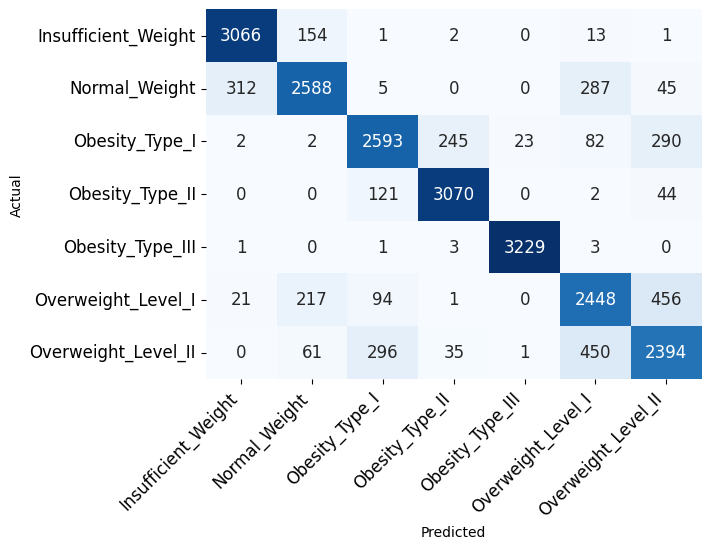



************Classfication report*************


              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3237
           1       0.86      0.80      0.83      3237
           2       0.83      0.80      0.82      3237
           3       0.91      0.95      0.93      3237
           4       0.99      1.00      1.00      3237
           5       0.75      0.76      0.75      3237
           6       0.74      0.74      0.74      3237

    accuracy                           0.86     22659
   macro avg       0.85      0.86      0.85     22659
weighted avg       0.85      0.86      0.85     22659

**********************************
Accuracy
0.8556423496182533
Function performance_metrics() Took 0.4461 seconds
Performance of lr on validation
Function predict() Took 0.0088 seconds
Classification report


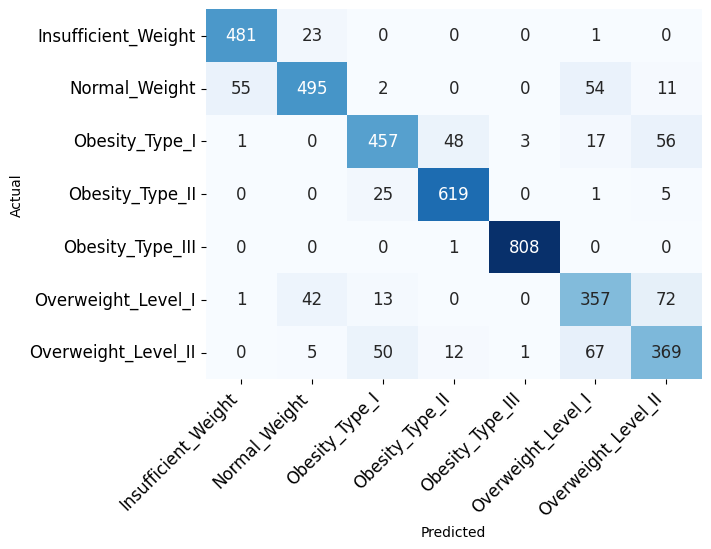



************Classfication report*************


              precision    recall  f1-score   support

           0       0.89      0.95      0.92       505
           1       0.88      0.80      0.84       617
           2       0.84      0.79      0.81       582
           3       0.91      0.95      0.93       650
           4       1.00      1.00      1.00       809
           5       0.72      0.74      0.73       485
           6       0.72      0.73      0.73       504

    accuracy                           0.86      4152
   macro avg       0.85      0.85      0.85      4152
weighted avg       0.86      0.86      0.86      4152

**********************************
Accuracy
0.8636801541425819
Function performance_metrics() Took 0.3649 seconds


In [36]:
n_trials = 2
n_splits = 5

# LR
study_lr = optuna.create_study(study_name = "lr", direction="maximize")
study_lr.optimize(lambda trial: objective_multiclass_lr(trial, X_train_smote, y_train_smote), n_trials=n_trials)
print(study_lr.best_params)

model_study_objs[study_lr.study_name] = study_lr

print("model training done......................")
print("retraining the models with best parameters")

best_models[study_lr.study_name] = train_best_model(X_train_smote, y_train_smote, model_name = study_lr.study_name, model = LogisticRegression(**model_study_objs[study_lr.study_name].best_params), preprocessTF=preprocess_transformer)

# best_svc = train_best_model(X_train, y_train, model_name = 'svc', model = LinearSVC(**model_best_params['svc']), preprocessTF=preprocess_transformer)
# best_xgb = train_best_model(X_train, y_train, model_name = 'xgb', model = XGBClassifier(**model_best_params['xgb']), preprocessTF=preprocess_transformer)
# best_cb = train_best_model(X_train, y_train, model_name = 'cb', model = CatBoostClassifier(**model_best_params['cb']), preprocessTF=preprocess_transformer)
# best_knn = train_best_model(X_train, y_train, model_name = 'knn', model = KNeighborsClassifier(**model_best_params['knn']), preprocessTF=preprocess_transformer)

print("**********************************************")
print("COMPUTING THE PERFORMANCE.....................")

performance_metrics(study_lr.study_name, "train", best_models[study_lr.study_name], X_train_smote, y_train_smote, le_target_mapping, preprocess_transformer)
performance_metrics(study_lr.study_name, "validation", best_models[study_lr.study_name], X_val_transformed, y_val, le_target_mapping, preprocess_transformer)

# grid_models = [grid_rf, grid_lr, grid_svc, grid_xgb, grid_knn, grid_cb]
# best_models = [best_rf, best_lr, best_svc, best_xgb, best_knn, best_cb]

# return le_target, preprocess_transformer # , grid_models, best_models

In [50]:
plot_optimization_history(study_lr).show()

In [51]:
plot_slice(study_lr).show()

In [52]:
plot_param_importances(study_lr).show()

[I 2024-10-21 04:10:35,866] A new study created in memory with name: svc


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:11:43,621] Trial 0 finished with value: 0.8550244924490948 and parameters: {'C': 25.696568799552175, 'loss': 'hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:11:44,758] Trial 1 finished with value: 0.7790282613273316 and parameters: {'C': 0.01101396942662731, 'loss': 'hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:12:47,668] Trial 2 finished with value: 0.8548920908294202 and parameters: {'C': 22.211631467137536, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:12:50,501] Trial 3 finished with value: 0.8316344908848974 and parameters: {'C': 0.052560636581406875, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:13:19,917] Trial 4 finished with value: 0.8546273168092009 and parameters: {'C': 2.315515414422973, 'loss': 'hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:14:25,362] Trial 5 finished with value: 0.8548479796821855 and parameters: {'C': 23.78030448321469, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:14:26,678] Trial 6 finished with value: 0.8172471274185892 and parameters: {'C': 0.02536712279970544, 'loss': 'hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:15:00,450] Trial 7 finished with value: 0.8549803520827298 and parameters: {'C': 5.850915373146467, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:15:22,453] Trial 8 finished with value: 0.8532151659753744 and parameters: {'C': 1.342395774897355, 'loss': 'hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:15:28,152] Trial 9 finished with value: 0.8503906889929393 and parameters: {'C': 0.37528551103663876, 'loss': 'hinge'}. Best is trial 0 with value: 0.8550244924490948.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:18:11,251] Trial 10 finished with value: 0.8553334165753894 and parameters: {'C': 91.04392187058873, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:20:54,030] Trial 11 finished with value: 0.8548038490555305 and parameters: {'C': 96.69201169047221, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:23:02,850] Trial 12 finished with value: 0.8551127537024048 and parameters: {'C': 68.24146876266369, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:25:39,892] Trial 13 finished with value: 0.8550244924490948 and parameters: {'C': 91.2652712844049, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:25:46,023] Trial 14 finished with value: 0.8481841089616436 and parameters: {'C': 0.26330089355987407, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:26:25,151] Trial 15 finished with value: 0.85506863281546 and parameters: {'C': 9.032176767569437, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:28:01,918] Trial 16 finished with value: 0.8552451650617897 and parameters: {'C': 42.91130816964047, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:28:34,206] Trial 17 finished with value: 0.8552010344351348 and parameters: {'C': 5.163919324020532, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:29:51,978] Trial 18 finished with value: 0.8551568843290596 and parameters: {'C': 32.710693434898346, 'loss': 'squared_hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:30:33,796] Trial 19 finished with value: 0.8549803618224401 and parameters: {'C': 9.872267565731708, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:30:37,198] Trial 20 finished with value: 0.8431088434035766 and parameters: {'C': 0.16025237857891333, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:31:05,540] Trial 21 finished with value: 0.8547596892097452 and parameters: {'C': 3.089470804717824, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:32:34,224] Trial 22 finished with value: 0.85498037156215 and parameters: {'C': 39.29393887293864, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:33:16,594] Trial 23 finished with value: 0.8550244924490948 and parameters: {'C': 10.031946802345292, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


 Tuning Linear SVM Model


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2024-10-21 04:33:47,080] Trial 24 finished with value: 0.8549803520827298 and parameters: {'C': 4.055403591738855, 'loss': 'hinge'}. Best is trial 10 with value: 0.8553334165753894.


{'C': 91.04392187058873, 'loss': 'hinge'}
model training done......................
retraining the models with best parameters
model_name =  svc
Function train_best_model() Took 12.4500 seconds
Performance of svc on train
Function predict() Took 0.0066 seconds
Classification report


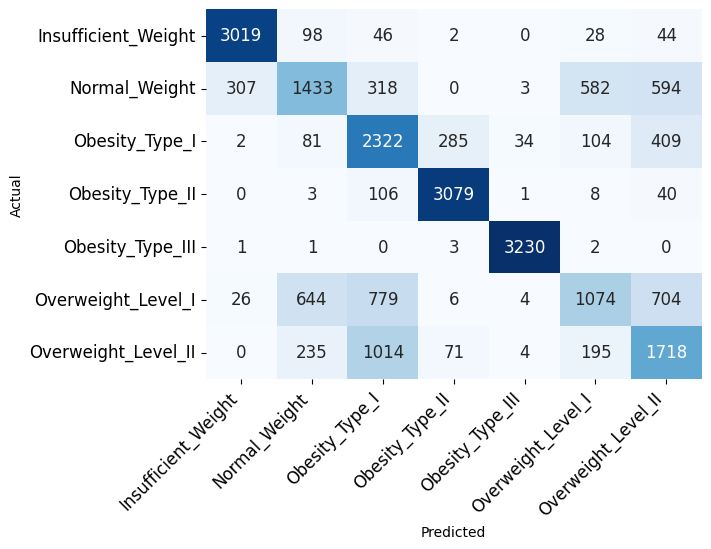



************Classfication report*************


              precision    recall  f1-score   support

           0       0.90      0.93      0.92      3237
           1       0.57      0.44      0.50      3237
           2       0.51      0.72      0.59      3237
           3       0.89      0.95      0.92      3237
           4       0.99      1.00      0.99      3237
           5       0.54      0.33      0.41      3237
           6       0.49      0.53      0.51      3237

    accuracy                           0.70     22659
   macro avg       0.70      0.70      0.69     22659
weighted avg       0.70      0.70      0.69     22659

**********************************
Accuracy
0.7006046162672669
Function performance_metrics() Took 0.4931 seconds
Performance of svc on validation
Function predict() Took 0.0046 seconds
Classification report


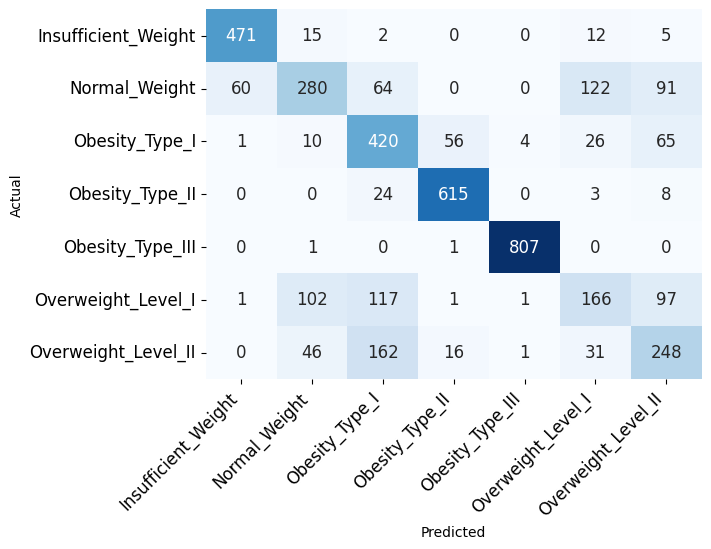



************Classfication report*************


              precision    recall  f1-score   support

           0       0.88      0.93      0.91       505
           1       0.62      0.45      0.52       617
           2       0.53      0.72      0.61       582
           3       0.89      0.95      0.92       650
           4       0.99      1.00      1.00       809
           5       0.46      0.34      0.39       485
           6       0.48      0.49      0.49       504

    accuracy                           0.72      4152
   macro avg       0.69      0.70      0.69      4152
weighted avg       0.72      0.72      0.72      4152

**********************************
Accuracy
0.7242292870905588
Function performance_metrics() Took 0.3839 seconds


In [ ]:
n_trials = 25
n_splits = 5

# SVC
study_svc = optuna.create_study(study_name = "svc", direction="maximize")
study_svc.optimize(objective_multiclass_svc, n_trials=n_trials)
print(study_svc.best_params)

model_study_objs[study_svc.study_name] = study_svc

print("model training done......................")
print("retraining the models with best parameters")

best_models['svc'] = train_best_model(X_train, y_train, model_name = 'svc', model = LinearSVC(**model_study_objs['svc'].best_params), preprocessTF=preprocess_transformer)

performance_metrics('svc', "train", best_models['svc'], X_train, y_train, le_target_mapping, preprocess_transformer)
performance_metrics('svc', "validation", best_models['svc'], X_val, y_val, le_target_mapping, preprocess_transformer)


In [ ]:
plot_slice(study_svc).show()

[I 2024-10-21 06:11:22,466] A new study created in memory with name: knn
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:12:08,443] Trial 0 finished with value: 0.7346308640116347 and parameters: {'n_neighbors': 2351, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 0 with value: 0.7346308640116347.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:12:53,533] Trial 1 finished with value: 0.7393972833610883 and parameters: {'n_neighbors': 2211, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 1 with value: 0.7393972833610883.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:13:30,340] Trial 2 finished with value: 0.7403240752193918 and parameters: {'n_neighbors': 2141, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 2 with value: 0.7403240752193918.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:14:06,447] Trial 3 finished with value: 0.74138324921795 and parameters: {'n_neighbors': 2001, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 3 with value: 0.74138324921795.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:14:49,942] Trial 4 finished with value: 0.7299527448743314 and parameters: {'n_neighbors': 2491, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 3 with value: 0.74138324921795.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:15:31,642] Trial 5 finished with value: 0.7373671186996006 and parameters: {'n_neighbors': 2281, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 3 with value: 0.74138324921795.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:16:08,826] Trial 6 finished with value: 0.7403240752193918 and parameters: {'n_neighbors': 2141, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 3 with value: 0.74138324921795.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:16:56,237] Trial 7 finished with value: 0.7321594807409894 and parameters: {'n_neighbors': 2421, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 3 with value: 0.74138324921795.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:17:39,821] Trial 8 finished with value: 0.740809531592016 and parameters: {'n_neighbors': 2071, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 3 with value: 0.74138324921795.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [2001, 2501] and step=70, but the range is not divisible by `step`. It will be replaced by [2001, 2491].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:704: UserWarning:

The distribution is specified by [3001, 3005] and step=90, but the range is not divisible by `step`. It will be replaced by [3001, 3001].



 Tuning KNN Model


[I 2024-10-21 06:18:15,813] Trial 9 finished with value: 0.740809531592016 and parameters: {'n_neighbors': 2071, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 3001, 'metric': 'euclidean'}. Best is trial 3 with value: 0.74138324921795.


{'n_neighbors': 2001, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 3001, 'metric': 'euclidean'}
model training done......................
retraining the models with best parameters
model_name =  knn
Function train_best_model() Took 0.0289 seconds
Performance of knn on train
Function predict() Took 110.1181 seconds
Classification report


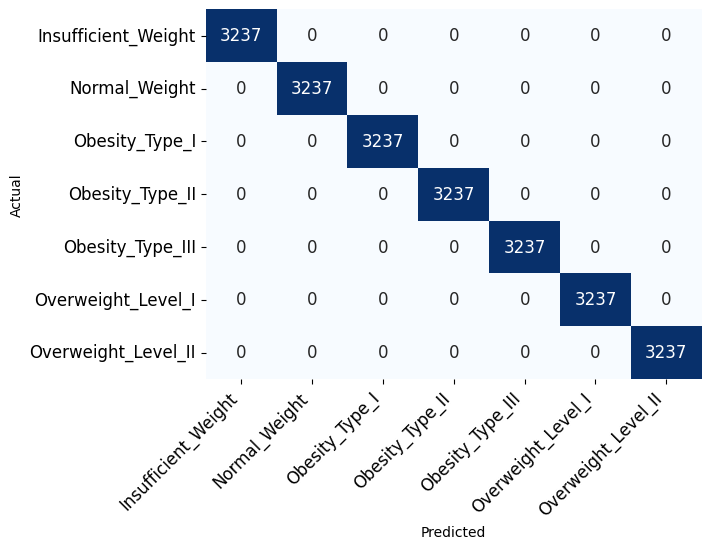



************Classfication report*************


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3237
           1       1.00      1.00      1.00      3237
           2       1.00      1.00      1.00      3237
           3       1.00      1.00      1.00      3237
           4       1.00      1.00      1.00      3237
           5       1.00      1.00      1.00      3237
           6       1.00      1.00      1.00      3237

    accuracy                           1.00     22659
   macro avg       1.00      1.00      1.00     22659
weighted avg       1.00      1.00      1.00     22659

**********************************
Accuracy
1.0
Function performance_metrics() Took 110.5442 seconds
Performance of knn on validation
Function predict() Took 18.7027 seconds
Classification report


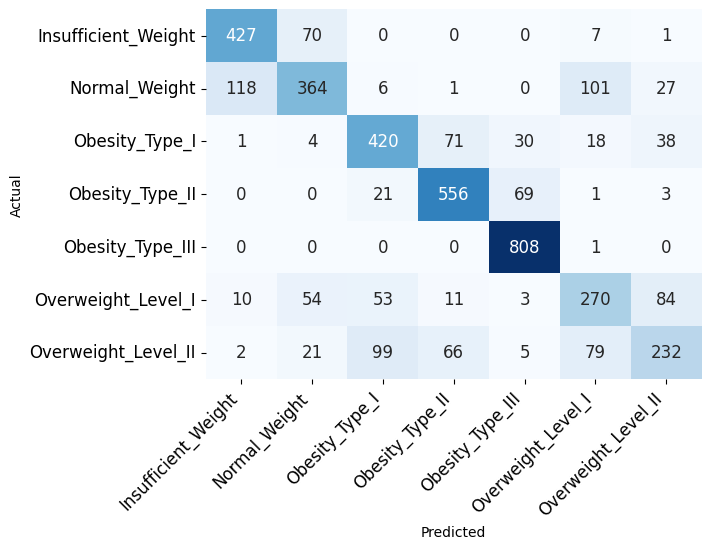



************Classfication report*************


              precision    recall  f1-score   support

           0       0.77      0.85      0.80       505
           1       0.71      0.59      0.64       617
           2       0.70      0.72      0.71       582
           3       0.79      0.86      0.82       650
           4       0.88      1.00      0.94       809
           5       0.57      0.56      0.56       485
           6       0.60      0.46      0.52       504

    accuracy                           0.74      4152
   macro avg       0.72      0.72      0.71      4152
weighted avg       0.73      0.74      0.73      4152

**********************************
Accuracy
0.7410886319845857
Function performance_metrics() Took 19.2483 seconds


In [ ]:
n_trials = 10
n_splits = 5

# KNN
study_knn = optuna.create_study(study_name = "knn", direction="maximize")
study_knn.optimize(objective_multiclass_knn, n_trials=n_trials)
print(study_knn.best_params)

model_study_objs[study_knn.study_name] = study_knn

print("model training done......................")
print("retraining the models with best parameters")

best_models['knn'] = train_best_model(X_train, y_train, model_name = 'knn', model = KNeighborsClassifier(**model_study_objs['knn'].best_params), preprocessTF=preprocess_transformer)

performance_metrics('knn', "train", best_models['knn'], X_train, y_train, le_target_mapping, preprocess_transformer)
performance_metrics('knn', "validation", best_models['knn'], X_val, y_val, le_target_mapping, preprocess_transformer)

In [ ]:
plot_slice(study_knn).show()

In [ ]:
best_models['knn'].predict_proba(X_val.iloc[0:1, :]), y_val.iloc[0:1]

(array([[0.        , 0.94302393, 0.        , 0.        , 0.        ,
         0.05697607, 0.        ]]),
 5442    1
 Name: NObeyesdad_label, dtype: int64)

In [ ]:
model_study_objs

{'cb': <optuna.study.study.Study at 0x7d4179b75510>,
 'rf': <optuna.study.study.Study at 0x7d4112092aa0>,
 'xgb': <optuna.study.study.Study at 0x7d4112093580>,
 'lr': <optuna.study.study.Study at 0x7d4112407df0>,
 'svc': <optuna.study.study.Study at 0x7d41124070a0>,
 'knn': <optuna.study.study.Study at 0x7d4113472a70>}

In [ ]:
model_study_objs['cb'].best_params, model_study_objs['cb'].best_value

({'iterations': 400,
  'depth': 6,
  'learning_rate': 0.12700623524288904,
  'l2_leaf_reg': 2,
  'bagging_temperature': 0.04859558247358453},
 0.8470616570327553)

In [ ]:
model_study_objs['rf'].best_params, model_study_objs['rf'].best_value

({'max_depth': 1,
  'n_estimators': 50,
  'min_samples_split': 2,
  'max_features': 'log2'},
 0.6153660886319846)

In [ ]:
best_models

{'cb': <catboost.core.CatBoostClassifier at 0x7d4111ff7490>,
 'rf': RandomForestClassifier(max_depth=5, max_features=None, min_samples_split=5,
                        n_estimators=300),
 'xgb': XGBClassifier(alpha=0.0005034668368572051, base_score=None, booster=None,
               callbacks=None, colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.4637788020367969, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eta=0.21158524116963223, eval_metric=None, feature_types=None,
               gamma=0.02450388192253617, grow_policy=None, importance_type=None,
               interaction_constraints=None, lambda=3.08377482243991e-05,
               learning_rate=0.01980366106768973, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               mu

In [ ]:
study_rf.best_trials

[FrozenTrial(number=24, state=TrialState.COMPLETE, values=[0.8702062753731624], datetime_start=datetime.datetime(2024, 10, 21, 1, 4, 5, 993037), datetime_complete=datetime.datetime(2024, 10, 21, 1, 4, 53, 774273), params={'max_depth': 10, 'n_estimators': 700, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': CategoricalDistribution(choices=(1, 3, 5, 10)), 'n_estimators': IntDistribution(high=700, log=False, low=100, step=100), 'min_samples_split': CategoricalDistribution(choices=(2, 5, 7, 10, 15)), 'min_samples_leaf': CategoricalDistribution(choices=(2, 5, 7, 10, 15)), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2'))}, trial_id=24, value=None)]

In [ ]:
xgb_best_trials = [trial for trial in study_xgb.trials if trial.value > 0.85]

# Display the hyperparameters for the filtered trials
for trial in xgb_best_trials:
    print(f"Trial {trial.number}:")
    print(f"  Score: {trial.value}")
    print(f"  Hyperparameters: {trial.params}")

Trial 0:
  Score: 0.8559956779062272
  Hyperparameters: {'booster': 'gbtree', 'lambda': 9.146488952886461e-07, 'alpha': 0.0008571129233672115, 'eta': 0.22730054787005682, 'gamma': 0.0042736088798631736, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.9257780300037184, 'colsample_bytree': 0.7486658976682068, 'learning_rate': 0.159854770692407, 'n_estimators': 750}
Trial 1:
  Score: 0.8649987835102033
  Hyperparameters: {'booster': 'gbtree', 'lambda': 0.018842931187686762, 'alpha': 1.7444722653300958e-06, 'eta': 0.2200690763632752, 'gamma': 0.0004542516500614893, 'max_depth': 6, 'min_child_weight': 13, 'subsample': 0.7756305385569565, 'colsample_bytree': 0.7919636157962211, 'learning_rate': 0.1433277000596398, 'n_estimators': 750}
Trial 2:
  Score: 0.8683086779064221
  Hyperparameters: {'booster': 'gbtree', 'lambda': 8.914703292834528e-05, 'alpha': 1.4400498230357204e-06, 'eta': 0.2026534372864715, 'gamma': 0.002568717557797491, 'max_depth': 8, 'min_child_weight': 14, 'subsample':

In [ ]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances

In [ ]:
plot_parallel_coordinate(study_xgb).show()

alpha = 1e-05 to 1e-08

colsample_bytree = 0.8 to 0.55

eta = 0.12 to 0.3

gamma = 1e-05 to 0.1

lambda = 1e-05 to 1.63-e08

learning rate = 0.1 to 0.2

max_depth = 9 to 12

min_child_weight = 1, 3, 10

n_estimators = 200 to 1000 step = 150

subsample = 0.7 to 0.9

In [53]:
model_study_objs

{'cb': <optuna.study.study.Study at 0x7cbba1c63a90>,
 'rf': <optuna.study.study.Study at 0x7cbba1c61ea0>,
 'xgb': <optuna.study.study.Study at 0x7cbb98e04a60>,
 'lr': <optuna.study.study.Study at 0x7cbb98c18ac0>}

In [54]:
best_models

{'cb': <catboost.core.CatBoostClassifier at 0x7cbbc419dae0>,
 'rf': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=7,
                        n_estimators=600),
 'xgb': XGBClassifier(alpha=0.2069022683322708, base_score=None, booster='gbtree',
               callbacks=None, colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.5802010024029889, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eta=0.1307835126005148, eval_metric=None, feature_types=None,
               gamma=0.8948630555014233, grow_policy=None, importance_type=None,
               interaction_constraints=None, lambda=0.7050170483300654,
               learning_rate=0.1996169667268899, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=15, missing=nan, monotone_constraints=None,
               mul

In [57]:
# save studies of models
model_names = model_study_objs.keys()

for model_name in model_names:
    # save_model(model_name, grid_name)
    print(model_study_objs[model_name])
    study_obj = model_study_objs[model_name]
    model_name = "/content/drive/MyDrive/capstone/medical/smote/study_" + f"{model_name}" + ".pkl"
    print("saving study object = " + model_name)
    with open(model_name, "wb") as f:
        dump(study_obj, f, protocol=5)

    print(f"Model saved at: {model_name}")

saving study object = /content/drive/MyDrive/capstone/medical/smote/study_cb.pkl
Model saved at: /content/drive/MyDrive/capstone/medical/smote/study_cb.pkl
saving study object = /content/drive/MyDrive/capstone/medical/smote/study_rf.pkl
Model saved at: /content/drive/MyDrive/capstone/medical/smote/study_rf.pkl
saving study object = /content/drive/MyDrive/capstone/medical/smote/study_xgb.pkl
Model saved at: /content/drive/MyDrive/capstone/medical/smote/study_xgb.pkl
saving study object = /content/drive/MyDrive/capstone/medical/smote/study_lr.pkl
Model saved at: /content/drive/MyDrive/capstone/medical/smote/study_lr.pkl


In [58]:
# save best models
model_names = best_models.keys()

for model_name in model_names:
    # save_model(model_name, grid_name)
    print(best_models[model_name])
    model_obj = best_models[model_name]
    model_name = "/content/drive/MyDrive/capstone/medical/smote/best_" + f"{model_name}" + ".pkl"
    print("saving study object = " + model_name)
    with open(model_name, "wb") as f:
        dump(model_obj, f, protocol=5)

    print(f"Model saved at: {model_name}")

saving study object = /content/drive/MyDrive/capstone/medical/smote/best_cb.pkl
Model saved at: /content/drive/MyDrive/capstone/medical/smote/best_cb.pkl
RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=7,
                       n_estimators=600)
saving study object = /content/drive/MyDrive/capstone/medical/smote/best_rf.pkl
Model saved at: /content/drive/MyDrive/capstone/medical/smote/best_rf.pkl
XGBClassifier(alpha=0.2069022683322708, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5802010024029889, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.1307835126005148, eval_metric=None, feature_types=None,
              gamma=0.8948630555014233, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.7050170483300654,
              learning_rate=0.1996169667268899, max_bin=None,
